# Package Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from math import sqrt, erf, exp
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import metrics as me
import GPy
import pickle
from catboost import CatBoostRegressor
import catboost as cb
from sklearn.preprocessing import StandardScaler
import shap
import tensorflow as tf
from sklearn import preprocessing
from tabulate import tabulate

# Functions and global variables

In [2]:
#A global variable that standardizes the data for the CatBoost model
standardize_cbr = False

In [3]:
# Variables required for target attainment prediction
free_MIC = 16
free_toxic_threshold = 112
protein_binding = 0.30 # percent
MIC = free_MIC/(1-protein_binding)
toxic_threshold = free_toxic_threshold/(1-protein_binding)

In [4]:
def cockcroft_gault(age,weight,creat_s,length,gender):
    BMI = weight/(length*length/(100*100))
    if gender == 1:
        IBW = 50+2.3*(length/2.54-60)
        ABW = IBW+0.4*(weight-IBW)
        
        if BMI < 18.5:
            w_u = weight
        elif BMI < 24.9:
            w_u = IBW
        else:
            w_u = ABW
        
        return (140-age)*w_u/(72*creat_s)
    else:
        IBW = 45.5+2.3*(length/2.54-60)
        ABW = IBW+0.4*(weight-IBW)
        
        if BMI < 18.5:
            w_u = weight
        elif BMI < 24.9:
            w_u = IBW
        else:
            w_u = ABW
            
        return (140-age)*w_u*(0.85)/(72*creat_s)
    
def CKD_EPI(creat_s,age,gender):
    if gender == 1:
        if creat_s < 0.9:
            return 141*(creat_s/0.9)**(-0.411)*0.993**age
        else:
            return 141*(creat_s/0.9)**(-1.209)*0.993**age
    else:
        if creat_s < 0.7:
            return 144*(creat_s/0.7)**(-0.329)*0.993**age
        else:
            return 144*(creat_s/0.7)**(-1.209)*0.993**age
        
def MDRD(creat_s,age,gender):
    if gender == 1:
        return 175*(creat_s)**(-1.154)*age**(-0.203)
    else:
        return 175*(creat_s)**(-1.154)*age**(-0.203) * 0.742

def clclr_missing(calc_train):
    cg_pred = []
    clcr_pred = []
    MDRD_pred = []
    for i in range(0,len(calc_train)):
        if calc_train['Cl8u_orig_-999'][i]==-999:
            cg_pred = np.append(cg_pred,cockcroft_gault(calc_train['Age'][i],calc_train['Weight'][i],calc_train['Creat_s'][i],calc_train['Length'][i],calc_train['Gender.M'][i]))
            clcr_pred = np.append(clcr_pred,CKD_EPI(calc_train['Creat_s'][i],calc_train['Age'][i],calc_train['Gender.M'][i]))
            MDRD_pred = np.append(MDRD_pred,MDRD(calc_train['Creat_s'][i],calc_train['Age'][i],calc_train['Gender.M'][i]))
        else:
            cg_pred = np.append(cg_pred,calc_train['Cl8u'][i])
            clcr_pred = np.append(clcr_pred,calc_train['Cl8u'][i])
            MDRD_pred = np.append(MDRD_pred,calc_train['Cl8u'][i])
    return cg_pred,clcr_pred,MDRD_pred

def clclr_missing_heroic(calc_train):
    cg_pred = []
    clcr_pred = []
    MDRD_pred = []
    for i in range(0,len(calc_train)):
        if calc_train['ClCr'][i]==0:
            cg_pred = np.append(cg_pred,cockcroft_gault(calc_train['Age'][i],calc_train['Weight'][i],calc_train['Serum Creat'][i],calc_train['Length'][i],calc_train['Gender'][i]))
            clcr_pred = np.append(clcr_pred,CKD_EPI(calc_train['Serum Creat'][i],calc_train['Age'][i],calc_train['Gender'][i]))
            MDRD_pred = np.append(MDRD_pred,MDRD(calc_train['Serum Creat'][i],calc_train['Age'][i],calc_train['Gender'][i]))
        else:
            cg_pred = np.append(cg_pred,calc_train['ClCr'][i])
            clcr_pred = np.append(clcr_pred,calc_train['ClCr'][i])
            MDRD_pred = np.append(MDRD_pred,calc_train['ClCr'][i])
    return cg_pred,clcr_pred,MDRD_pred

def clclr_missing_aard(calc_train):
    cg_pred = []
    clcr_pred = []
    MDRD_pred = []
    for i in range(0,len(calc_train)):
        if calc_train['Creat_u'][i]==-1:
            cg_pred = np.append(cg_pred,cockcroft_gault(calc_train['Age'][i],calc_train['Weight'][i],calc_train['Creat_s'][i],calc_train['Length'][i],calc_train['Gender.M'][i]))
            clcr_pred = np.append(clcr_pred,CKD_EPI(calc_train['Creat_s'][i],calc_train['Age'][i],calc_train['Gender.M'][i]))
            MDRD_pred = np.append(MDRD_pred,MDRD(calc_train['Creat_s'][i],calc_train['Age'][i],calc_train['Gender.M'][i]))
        else:
            cg_pred = np.append(cg_pred,calc_train['Cl8u_-999'][i])
            clcr_pred = np.append(clcr_pred,calc_train['Cl8u_-999'][i])
            MDRD_pred = np.append(MDRD_pred,calc_train['Cl8u_-999'][i])
    return cg_pred,clcr_pred,MDRD_pred


In [13]:
feature_log = [
   """ 13,
    21,
    2,
    4,
    16,
    7,
    8,
    11,
    12,
    15,
    18,
    19,
    3,
    23"""
]



def train_standardizer(array,feature_idx):
    if feature_idx in feature_log:
        if feature_idx == 3 or feature_idx == 23:
            array = np.log(array+1)
        else:
            array = np.log(array)
            
    if feature_idx == 23:
        feature_Scalers[feature_idx] = feature_Scalers[3]
    else:
        feature_Scalers[feature_idx].fit(np.reshape(array,(-1,1)))
    
def Standardize(array,feature_idx):
    if feature_idx in feature_log:
        if feature_idx == 3:
            array = np.log(array+1)
        else:
            array = np.log(array)
    return feature_Scalers[feature_idx].transform(np.reshape(array,(-1,1)))[:,0]
    

def deStandardize(array,XorY,feature):
    if XorY == 'Y':
        return feature_Scalers[23].inverse_transform(np.reshape(array,(-1,1)))[:,0]#np.exp(feature_Scalers[23].inverse_transform(np.reshape(array,(-1,1)))[:,0])
    else:
        return feature_Scalers[feature].inverse_transform(np.reshape(array,(-1,1)))[:,0]


# Data import and preprocessing

In [5]:
train_df = pd.read_csv(r"Data/REACT/DatasetFinal_FullVersionPIP3.csv", encoding = "ISO-8859-1")

train_df['DoseHour'] = train_df['DoseAdm']/train_df['Duration']
# Time to the previous sample of the same sample
train_df['time_to_prevCon'] = 0
train_df.loc[train_df.prevCon>0,'time_to_prevCon'] = train_df[train_df.prevCon>0]['Duration']

# Calculate the ClCr of missing values using the weighted formula
cock_gault,ckd_epi,MD_RD=clclr_missing(train_df)
train_df['Cl8u_eGFR'] = (cock_gault+2*MD_RD)/3

train_df = train_df.rename(columns={"LactVB":"Lactate","Creat_s":"Serum Creat","Bili":"Bilirubine","Cl8u_eGFR":"ClCr","VB":"Fluid Balance"})
train_df_new = train_df[train_df.prevCon == 0] 
train_df_prev= train_df[train_df.prevCon > 0]

Y_prev = train_df_prev.concentration.values
Y_new = train_df_new.concentration.values


validation_pd = pd.read_csv(r"Data/REACT/ML_val_Aardema_complete_24.csv", encoding = "ISO-8859-1")

validation_pd["DateConcNs"] = pd.to_datetime(validation_pd.DateConc,format='%d/%m/%Y %H:%M').astype(np.int64)//10**6
validation_pd['time_to_prevCon']=np.append(0,validation_pd.DateConcNs[1:].values-validation_pd.DateConcNs[:-1].values)
validation_pd.loc[validation_pd.prevCon==0,'time_to_prevCon'] = 0
validation_pd.loc[:,'time_to_prevCon'] = validation_pd.loc[:,'time_to_prevCon']/1000/60/60

validation_pd['LactVB']=validation_pd['LactVB']*10
validation_pd['ClCr']=validation_pd['Cl8u_-999']

# There was no Dose per Hour data available in the external dataset, so we used the average, 
# However, as this feature is not very important in the final model, this has no real effect
validation_pd['DoseHour'] = 500
validation_pd = validation_pd.rename(columns={"LactVB":"Lactate","Creat_s":"Serum Creat","Bili":"Bilirubine","Cl8u_eGFR":"ClCr","VB":"Fluid Balance"})

validation_pd_999 = validation_pd.fillna(-999)
validation_pd = validation_pd.fillna(validation_pd.mean())

Y_val_un = validation_pd.concentration.values


In [14]:
featureString = {
1:'Cl8u',
2:'Serum Creat',
3:'prevCon',
4:'Bilirubine',
5:'Length',
6:'Temp',
7:'HCT',
8:'Albumine',
9:'Fluid Balance',
10:'SOFA',
11:'DoseAdm',
12:'Thrombo',
13:'Weight',
14:'Age',
15:'Creat_u',
16:'WBC',
17:'RBC',
18:'HgB',
19:'CumSum',
20:'DoseHour',
21:'Lactate',
22:'KDIGO',
23:'concentration',
24:'Neuro',
25:'Adm.category_trauma',
26:'ClCr'
}

featureString_val = {
1:'Cl8u_-999',
2:'Serum Creat',
3:'prevCon',
4:'Bilirubine',
5:'Length',
6:'NO',
7:'NO',
8:'Albumine',
9:'Fluid Balance',
10:'SOFA',
11:'DoseAdm',
12:'Thrombo',
13:'Weight',
14:'Age',
15:'Creat_u',
16:'WBC',
17:'NO',
18:'HgB',
19:'NO',
20:'DoseHour',
21:'Lactate',
22:'NO',
23:'concentration',
24:'NO',
25:'NO',
26:'ClCr'
}

feature_Scalers = {
1:StandardScaler(),
2:StandardScaler(),
3:StandardScaler(),
4:StandardScaler(),
5:StandardScaler(),
6:StandardScaler(),
7:StandardScaler(),
8:StandardScaler(),
9:StandardScaler(),
10:StandardScaler(),
11:StandardScaler(),
12:StandardScaler(),
13:StandardScaler(),
14:StandardScaler(),
15:StandardScaler(),
16:StandardScaler(),
17:StandardScaler(),
18:StandardScaler(),
19:StandardScaler(),
20:StandardScaler(),
21:StandardScaler(),
22:StandardScaler(),
23:StandardScaler(),
24:StandardScaler(),
25:StandardScaler(),
26:StandardScaler()
}

## External/Internal selection and Training test split

In [16]:
internal_test_bool = False

if internal_test_bool:
    # Make a test set with patients that have no missing ClCr values and at least two measurements
    df2 = train_df[train_df['Cl8u_-999']!=-999]
    df2 = df2[df2.prevCon>0].copy(deep=True)

    # Create the patient list with the amount of measurements for stratification
    patientlist = list(set(df2['PatientID'].tolist()))
    num_of_meas = []
    for patient in patientlist:
        num_of_meas.append(df2[df2['PatientID'] == patient].count()['PatientID'])

    for i in range(0,len(num_of_meas)):
        if num_of_meas[i]>9:
            num_of_meas[i] = 9

    #Train-test split
    patient_train, patient_test = train_test_split(patientlist,test_size = 0.25,stratify=num_of_meas,random_state = 1 )

    df2 = train_df[train_df['PatientID'].isin(patient_test)].copy(deep=True)
    test_df_cbr = df2
    validation_pd = df2
    Y_val_un = validation_pd.concentration.values

    train_df_split = train_df[~train_df['PatientID'].isin(validation_pd.PatientID)].copy(deep=True)

    train_df_prev = train_df_split[train_df_split.prevCon > 0].copy(deep=True)
    train_df_new = train_df_split[train_df_split.prevCon == 0].copy(deep=True)
    train_df_tot = train_df_split.copy(deep=True)
    
    train_df_cbr_prev = train_df_prev.copy(deep=True)
    train_df_cbr_new = train_df_new.copy(deep=True)
    
    #Prev = A posteriori test
    test_df_cbr_prev = validation_pd[validation_pd.prevCon > 0]
    #Prev = A priori test
    test_df_cbr_new = validation_pd[validation_pd.prevCon >= 0].copy(deep=True)
    
    # The var-model is the CBR New model in the paper, the previous "new" dataset is for GP New. As both use different datasets these have different names
    train_df_cbr_var = train_df_split[(train_df_split.prevCon==0)|((train_df_split.prevCon > 0) & (np.abs(train_df_split.concentration_diff)>10))].copy(deep=True)
    test_df_cbr_var = validation_pd[validation_pd.prevCon>=0]
    Y_val_popPK = test_df_cbr.copy(deep=True).concentration.values
else:
    train_df_tot = train_df.copy(deep=True)
    test_df_cbr = validation_pd_999
    test_df_cbr_prev = validation_pd_999.copy(deep=True)
    train_df_cbr_prev = train_df_prev.copy(deep=True)
    train_df_cbr_new = train_df_new.copy(deep=True)
    test_df_cbr_prev = validation_pd_999[validation_pd_999.prevCon > 0].copy(deep=True)
    test_df_cbr_new = validation_pd_999[validation_pd_999.prevCon >= 0].copy(deep=True)
    train_df_cbr_var = train_df[(train_df.prevCon==0)|((train_df.prevCon > 0) & (train_df.concentration_diff>10))].copy(deep=True)
    test_df_cbr_var = validation_pd_999[validation_pd_999.prevCon>=0].copy(deep=True)

val_pd_new = validation_pd[validation_pd.prevCon >= 0].copy(deep=True)
val_pd_prev = validation_pd[validation_pd.prevCon > 0].copy(deep=True)
val_pd_tot = validation_pd.copy(deep=True)
val_pd_tot_nostand = validation_pd.copy(deep=True)
Y_val_new = val_pd_new.concentration.values
Y_val_prev = val_pd_prev.concentration.values
Y_prev = train_df_prev.concentration.values
Y_new = train_df_new.concentration.values

In [17]:
noprev_df = train_df[train_df.prevCon>0].copy(deep=True)

train_df_prev_temp = train_df_prev.copy(deep=True)
train_df_new_temp = train_df_new.copy(deep=True)

#Standardization
for i in range(1,27):
    feat = featureString[i]
    feat_val = featureString_val[i]

    #This special construction is to ensure the same standardisation as in the original file
    #Because of we just use train_df_prev this set is already modified (two blocks above)
    #Splitting after standardisation is more difficult because 0 is not 0 anymore but less

    train_standardizer(noprev_df[feat].values,i)
    
    train_df_prev_temp.loc[:,feat] = Standardize(train_df_prev[feat].values,i)

    train_df_new_temp.loc[:,feat] =  Standardize(train_df_new[feat].values,i)
    
    if standardize_cbr:
        train_df_cbr.loc[:,feat] = Standardize(train_df_cbr[feat].values,i) 
        print("boo")

    
    
    if internal_test_bool:
        if standardize_cbr:
            test_df_cbr.loc[:,feat] =  Standardize(test_df_cbr[feat].values,i) 
        val_pd_tot.loc[:,feat] = Standardize(val_pd_tot[feat].values,i) 
        val_pd_new.loc[:,feat] = Standardize(val_pd_new[feat].values,i) 
        val_pd_prev.loc[:,feat] = Standardize(val_pd_prev[feat].values,i) 
    else:
        if feat_val != 'NO':
            if standardize_cbr:
                test_df_cbr.loc[:,feat_val] = Standardize(test_df_cbr[feat_val].values,i) 
            val_pd_new.loc[:,feat_val] = Standardize(val_pd_new[feat_val].values,i) 
            val_pd_prev.loc[:,feat_val] = Standardize(val_pd_prev[feat_val].values,i) 

train_df_new = train_df_new_temp.copy(deep=True)
train_df_prev = train_df_prev_temp.copy(deep=True)         
            
Y_prev = train_df_prev['concentration'].values #Standardize_value(Y)
    
Y_val_new = val_pd_new['concentration'].values
Y_val_prev = val_pd_prev['concentration'].values
Y_val_tot = val_pd_tot['concentration'].values

Y_new = train_df_new['concentration'].values

In [18]:
Y_cbr_test_new = test_df_cbr_new['concentration'].values
Y_cbr_test_prev = test_df_cbr_prev['concentration'].values

Y_cbr_test = validation_pd['concentration'].values/validation_pd['DoseHour'].values


Y_cbr_train_new = train_df_cbr_new['concentration'].values
Y_cbr_train_prev = train_df_cbr_prev['concentration'].values

Y_cbr_train_var = train_df_cbr_var['concentration'].values
Y_cbr_test_var = test_df_cbr_var['concentration'].values

In [19]:
# Data shape fixing
Y_prev = np.reshape(Y_prev,(-1,1))
Y_new = np.reshape(Y_new,(-1,1))
Y_val_un = np.reshape(Y_val_un,(-1,1))

In [20]:
if not internal_test_bool:
    val_pd_new = val_pd_new.rename(columns={"Cl8u_-999": "Cl8u"})
    val_pd_prev = val_pd_prev.rename(columns={"Cl8u_-999": "Cl8u"})

# Models

## Preprocessing

In [23]:
def gp_model_prev(X_arg,Y_arg,amountFeatures):
    kernel = GPy.kern.MLP(input_dim=amountFeatures,ARD=True)
    gp = GPy.models.GPRegression(X_arg,Y_arg,kernel)
    return gp

def gp_model_new(X_arg,Y_arg,amountFeatures):
    #kernel = GPy.kern.Matern52(input_dim=amountFeatures,ARD=True)
    kernel = GPy.kern.RBF(input_dim=amountFeatures,ARD=True)
    gp = GPy.models.GPRegression(X_arg,Y_arg,kernel)
    return gp

def gp_model_tot(X_arg,Y_arg,amountFeatures):
    kernel = GPy.kern.Matern52(input_dim=amountFeatures,ARD=True)
    gp = GPy.models.GPRegression(X_arg,Y_arg,kernel)
    return gp

# Give continuous concentrations a target attainment class
def to_pred_classes(Y_prediction,stand):
    if stand:
        class_t = deStandardize(Y_prediction[0],'Y',-1)
    else:
        class_t = Y_prediction
    class_pred = []
    for el in class_t:
        if el < 4*MIC:
            class_pred = np.append(class_pred,"U")#Underdosing")
        elif el < toxic_threshold:
            class_pred = np.append(class_pred,"A")#dequate dosing")
        else:
            class_pred = np.append(class_pred,"O")#verdosing")
    return class_pred

def get_X_features(features,X):
    return  X[features].astype(np.float32).to_numpy()

In [24]:
Featurelist_prev = ['prevCon','ClCr','Bilirubine','Fluid Balance'] #'Albumine','VB','Bili'
Featurelist_new = ['ClCr','Albumine','Length']#'Bili','Age','Adm.category_trauma']#]# 'Thrombo','Length','Albumine' 

## CatBoost

In [25]:
preprocessed_columns_new = ['Age',
                        'Length',
                        'Lactate',
                        'Serum Creat',
                        'WBC',
                        'Bilirubine',
                        'Fluid Balance',
                        'Albumine']


preprocessed_columns_prev = ['Length',
                        'Serum Creat',
                        'Thrombo',
                        'Bilirubine',
                        'Albumine',
                        'DoseHour']

X_columns_henri = ['Creat_s','Cl8u_-999','prevCon','Length','Albumine','Adm.category_trauma','Bili','Thrombo','VB','WBC','LactVB','Age','Weight','DoseHour'] 
X_columns_timothy = ['Cl8u','Creat_s','prevCon','Length','Bili','Albumine','HCT','VB','Thrombo','LactVB','Weight','Adm.category_trauma','Creat_u','Temp','WBC','INtot','DoseAdm','SOFA']
                     

preprocessed_columns_var = ['Age',
                        'Length',
                        'Lactate',
                        'Serum Creat',
                        'Bilirubine',
                        'Albumine']


                        
extension_cl = ['ClCr']
extension_temp = []
extension_creat = []

extension_conc = ['prevCon']
X_columns_prev = np.concatenate([preprocessed_columns_prev, extension_conc, extension_cl, extension_creat, extension_temp])
X_cbr_train_prev = train_df_cbr_prev[X_columns_prev]
X_cbr_test_prev = test_df_cbr_prev[X_columns_prev]


X_columns_var = np.concatenate([preprocessed_columns_var, extension_cl])

X_cbr_train_var = train_df_cbr_var[X_columns_var]
X_cbr_test_var = test_df_cbr_var[X_columns_var]

In [26]:
cat_cols_prev = list(X_cbr_train_prev.select_dtypes(include='object').columns)
cat_cols_idx_prev = []
for col_idx, col in enumerate(X_cbr_train_prev.columns):
     if col in cat_cols_prev:
            cat_cols_idx_prev.append(col_idx)
            
cat_cols_var = list(X_cbr_train_var.select_dtypes(include='object').columns)
cat_cols_idx_var = []
for col_idx, col in enumerate(X_cbr_train_var.columns):
     if col in cat_cols_var:
            cat_cols_idx_var.append(col_idx)

In [27]:
from scipy.special import erfinv
from math import sqrt, erf

# Specify the p for the distribution prediction
Quantile_size_prev = 0.88
mult_quantile_prev = erfinv(Quantile_size_prev)*sqrt(2)
q_size_new = 0.9
mult_quantile_new = erfinv(q_size_new)*sqrt(2)
q_size_var = 0.88#0.879
mult_quantile_var = erfinv(q_size_var)*sqrt(2)

In [28]:
#Iteration Hyperparameter
if internal_test_bool:
    it_q50_prev = 336
    it_qlow_prev = 202
    it_qhigh_prev = 166
    it_q50_new = 430
    it_qlow_new = 165
    it_qhigh_new = 177
else:    
    it_q50_prev = 273
    it_qlow_prev = 236
    it_qhigh_prev = 142
    it_q50_new = 236
    it_qlow_new = 172
    it_qhigh_new = 145

In [29]:
if internal_test_bool:
    it_q50_var = 388#245
    it_qlow_var = 119#118
    it_qhigh_var = 158#93
else:
    it_q50_var = 359
    it_qlow_var = 182
    it_qhigh_var = 167

In [30]:
cbr_quant_low_prev = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha='+str(0.50-Quantile_size_prev/2),
                                iterations=it_qlow_prev, use_best_model=False, depth = 3,l2_leaf_reg=7,border_count=187,boost_from_average=False)
cbr_quant_low_prev.fit(X_cbr_train_prev, Y_cbr_train_prev, eval_set=(X_cbr_test_prev, Y_cbr_test_prev))

cbr_quant_high_prev = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha='+str(0.50+Quantile_size_prev/2),
                                iterations=it_qhigh_prev, use_best_model=False, depth = 3,l2_leaf_reg=7,border_count=187,boost_from_average=False)
cbr_quant_high_prev.fit(X_cbr_train_prev, Y_cbr_train_prev, eval_set=(X_cbr_test_prev, Y_cbr_test_prev))


In [31]:
cbr_quant_low_var = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha='+str(0.50-q_size_var/2),
                                iterations=it_qlow_var, use_best_model=False, depth = 4,l2_leaf_reg=12,border_count=213,boost_from_average=False)
cbr_quant_low_var.fit(X_cbr_train_var, Y_cbr_train_var, cat_features=cat_cols_var, eval_set=(X_cbr_test_var, Y_cbr_test_var))

cbr_quant_high_var = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha='+str(0.50+q_size_var/2),
                                iterations=it_qhigh_var, use_best_model=False, depth = 4,l2_leaf_reg=12,border_count=213,boost_from_average=False)
cbr_quant_high_var.fit(X_cbr_train_var, Y_cbr_train_var, cat_features=cat_cols_var, eval_set=(X_cbr_test_var, Y_cbr_test_var))


In [32]:
y_pred_test_cbr_low_prev = cbr_quant_low_prev.predict(X_cbr_test_prev)
y_pred_test_cbr_high_prev = cbr_quant_high_prev.predict(X_cbr_test_prev)

In [33]:
y_pred_test_cbr_low_var = cbr_quant_low_var.predict(X_cbr_test_var)
y_pred_test_cbr_high_var = cbr_quant_high_var.predict(X_cbr_test_var)
#Calculate the sigma of the Gaussian distribution.
y_pred_sigm_var = np.subtract(y_pred_test_cbr_high_var,y_pred_test_cbr_low_var)/(2*mult_quantile_var)

In [34]:
y_var_train_low = cbr_quant_low_var.predict(X_cbr_train_var)
y_var_train_high = cbr_quant_high_var.predict(X_cbr_train_var)
var_sigma_train = np.subtract(y_var_train_high,y_var_train_low)/(2*mult_quantile_var)

y_prev_train_low = cbr_quant_low_prev.predict(X_cbr_train_prev)
y_prev_train_high = cbr_quant_high_prev.predict(X_cbr_train_prev)
prev_sigma_train = np.subtract(y_prev_train_high,y_prev_train_low)/(2*mult_quantile_prev)

In [35]:
y_pred_sigm_prev = np.subtract(y_pred_test_cbr_high_prev,y_pred_test_cbr_low_prev)/(2*mult_quantile_prev)

In [36]:

cbr_prev = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha=0.5',
                                iterations=it_q50_prev, use_best_model=False, depth = 3,l2_leaf_reg=7,border_count=187,boost_from_average=False)

cbr_prev.fit(X_cbr_train_prev, Y_cbr_train_prev, cat_features=cat_cols_prev, eval_set=(X_cbr_test_prev, Y_cbr_test_prev))


In [37]:
#boost_from_average on false to get to 0.17.5 values
cbr_var = CatBoostRegressor(random_seed=42, verbose=False, one_hot_max_size=5, loss_function='Quantile:alpha=0.5',
                                iterations=it_q50_var, use_best_model=False, depth = 4,l2_leaf_reg=12,border_count=213,bootstrap_type='Bayesian',boost_from_average=False)
cbr_var.fit(X_cbr_train_var, Y_cbr_train_var, cat_features=cat_cols_idx_var, eval_set=(X_cbr_test_var, Y_cbr_test_var))

In [38]:
y_pred_test_cbr_var = cbr_var.predict(X_cbr_test_var)

In [39]:
#Y_cbr_train_var
cbr_var_train_pred = cbr_var.predict(X_cbr_train_var)
#Y_cbr_train_prev
cbr_prev_train_pred = cbr_prev.predict(X_cbr_train_prev)

In [40]:
if standardize_cbr:
    y_pred_test_cbr = deStandardize(cbr.predict(X_cbr_test),'Y',-1)
else:
    y_pred_test_cbr_prev = cbr_prev.predict(X_cbr_test_prev)

if standardize_cbr:
    y_pred_train_cbr = deStandardize(cbr.predict(X_cbr_train),'Y',-1)
else:
    y_pred_test_cbr_prev = cbr_prev.predict(X_cbr_test_prev)

if standardize_cbr:
    Y_cbr_test_dest = deStandardize(Y_cbr_test,'Y',-1)
else:
    Y_cbr_test_dest = Y_cbr_test

## PopPK

In [41]:
if internal_test_bool:
    popPK_pred_bet = pd.read_csv(r"Data/REACT/sdtab1000.csv", encoding = "ISO-8859-1")

    GUH_poppk = popPK_pred_bet[(popPK_pred_bet.DV>0) & (popPK_pred_bet.STDY==1)]
    popPK_inp_ISIS = pd.read_csv(r"Data/REACT/obspredPopPK.csv", encoding = "ISO-8859-1")
    popPK_inp_ISIS = popPK_inp_ISIS.rename(columns={"#ID":"ID"}).drop_duplicates()
    GUH_poppk_isis = GUH_poppk.merge(popPK_inp_ISIS[popPK_inp_ISIS.ID.isin(GUH_poppk.ID)][["ID","ISISID"]].drop_duplicates(),on="ID").rename_axis("OrIndex")
    df_popPK_test = GUH_poppk_isis[GUH_poppk_isis.ISISID.isin(test_df_cbr.PatientID)].sort_values(["ISISID","OrIndex"])[["ISISID","DV","PRED","IPRED","EVID"]]

    Y_test_popPK = np.array(df_popPK_test['DV'])
    Y_popPK_pred = np.array(df_popPK_test['PRED'])

    Y_test_popPK_prev = np.array(df_popPK_test[df_popPK_test.EVID==2.0]['DV'])
    Y_popPK_pred_prev = np.array(df_popPK_test[df_popPK_test.EVID==2.0]['IPRED'])
else:
    excluded_idx = [ 1,  3,  6,  8, 10, 12, 14, 16, 18, 22, 24, 26, 28, 30, 32, 34, 36,
       38, 40, 42, 44, 46, 49, 51, 53, 55, 57, 59, 62, 64, 68, 69, 71, 73,
       74, 76, 78, 80, 82, 84, 86]
    popPK_pred_bet = pd.read_csv(r"Data/REACT/sdtab1000.csv", encoding = "ISO-8859-1")
    GUH_poppk = popPK_pred_bet[(popPK_pred_bet.DV>0) & (popPK_pred_bet.STDY==2)].rename_axis('OrIndex')
    GUH_poppk = GUH_poppk.drop_duplicates(subset=["ID","DV"])
    df_popPK_test = GUH_poppk.sort_values(["ID","OrIndex"]).reset_index()[["ID","DV","PRED","IPRED","EVID"]].drop(excluded_idx)

    Y_test_popPK = np.array(df_popPK_test['DV'])
    Y_popPK_pred = np.array(df_popPK_test['PRED'])

    Y_test_popPK_prev = np.array(df_popPK_test[df_popPK_test.EVID==2.0]['DV'])
    Y_popPK_pred_prev = np.array(df_popPK_test[df_popPK_test.EVID==2.0]['IPRED'])

## Gaussian Process

In [42]:
X_prev = get_X_features(Featurelist_prev,train_df_prev)
X_new = get_X_features(Featurelist_new,train_df_new)

gp_prev = gp_model_prev(X_prev,Y_prev,len(Featurelist_prev))
gp_new = gp_model_new(X_new,Y_new,len(Featurelist_new))

In [43]:
gp_prev.optimize(messages=False)
gp_new.optimize(messages=False)

In [44]:
total = False
val_prev = get_X_features(Featurelist_prev,val_pd_prev)
val_new = get_X_features(Featurelist_new,val_pd_new)

if total:
    val_new=np.vstack([val_new,get_X_features(Featurelist_new,val_pd_prev)])
    Y_val_new_a = np.append(Y_val_new,Y_val_prev)
    Y_val_new_dest = deStandardize(np.reshape(Y_val_new_a,(-1,1)),'Y',-1)
else:
    Y_val_new_dest = deStandardize(np.reshape(Y_val_new,(-1,1)),'Y',-1)

Y_val_prev_dest = deStandardize(np.reshape(Y_val_prev,(-1,1)),'Y',-1)

In [45]:
Y_train_prev_dest = deStandardize(np.reshape(Y_prev,(-1,1)),'Y',-1)
Y_train_new_dest = deStandardize(np.reshape(Y_new,(-1,1)),'Y',-1)
train_pred_prev = deStandardize(gp_prev.predict_noiseless(X_prev)[0],'Y',-1)
train_pred_new = deStandardize(gp_new.predict_noiseless(X_new)[0],'Y',-1)

In [46]:
val_pred_prev = deStandardize(gp_prev.predict_noiseless(val_prev)[0],'Y',-1)
val_pred_new = deStandardize(gp_new.predict_noiseless(val_new)[0],'Y',-1)

In [47]:
#link https://en.wikipedia.org/wiki/Error_function

#underdosing, calc sigma, then calc how many sigma's to each border, erf with that many

quantiles_new = gp_new.predict_quantiles(val_new,quantiles=[2.5,97.5]) #
quantiles_prev = gp_prev.predict_quantiles(val_prev,quantiles=[2.5,97.5])

sigma_new = np.subtract(deStandardize(quantiles_new[1],'Y',-1),deStandardize(quantiles_new[0],'Y',-1))/(2*1.959963984540)
sigma_prev = np.subtract(deStandardize(quantiles_prev[1],'Y',-1),deStandardize(quantiles_prev[0],'Y',-1))/(2*1.959963984540)

sigmas = np.append(sigma_new,sigma_prev)
real_conc = np.append(Y_val_new_dest,Y_val_prev_dest)
preds = np.append(val_pred_new,val_pred_prev)

## Neural Network

In [48]:
if internal_test_bool:
    priori_MLP = tf.keras.models.load_model('REACT_models/priori_GUH')
    post_MLP = tf.keras.models.load_model('REACT_models/posteriori_GUH')
else:
    priori_MLP = tf.keras.models.load_model('REACT_models/priori_UMCG')
    post_MLP = tf.keras.models.load_model('REACT_models/posteriori_UMCG')
    
MLP_input_columns = [
    'Lactate',
    'Serum Creat',
    'Thrombo',
    'Bilirubine',
    'Fluid Balance',
    'Albumine',
    'DoseHour',
    'Age',
    'Length'
]

extension_conc = ['prevCon']
extension_cl8u = ['Cl8u_-999']

priori_feat = np.concatenate([MLP_input_columns,extension_cl8u])
post_feat = np.concatenate([MLP_input_columns,extension_conc,extension_cl8u])

prior_scaler = preprocessing.MinMaxScaler((0, 1))
post_scaler = preprocessing.MinMaxScaler((0, 1))

conc_post_scaler = preprocessing.MinMaxScaler((0, 1))
conc_priori_scaler = preprocessing.MinMaxScaler((0, 1))

prior_scaler.fit(train_df_tot[priori_feat])
post_scaler.fit(train_df_tot[train_df_tot.prevCon>0][post_feat])

conc_post_scaler.fit(train_df_tot[train_df_tot.prevCon>0].concentration.values.reshape(-1, 1))
conc_priori_scaler.fit(train_df_tot.concentration.values.reshape(-1, 1))

mlp_x_prior_val = prior_scaler.transform(val_pd_tot_nostand[priori_feat])
mlp_x_post_val = post_scaler.transform(val_pd_tot_nostand[val_pd_tot_nostand.prevCon>0][post_feat])

mlp_y_prior_val = val_pd_tot_nostand.concentration.values
mlp_y_post_val = val_pd_tot_nostand[val_pd_tot_nostand.prevCon>0].concentration.values

mlp_pred_prior = conc_priori_scaler.inverse_transform(priori_MLP.predict(tf.convert_to_tensor(mlp_x_prior_val)))[:,0]
mlp_pred_post = conc_post_scaler.inverse_transform(post_MLP.predict(tf.convert_to_tensor(mlp_x_post_val)))[:,0]

# Evaluation

In [49]:
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = me.r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = sqrt(me.mean_squared_error(Y,Y_pred))
    MAE_total = me.mean_absolute_error(Y,Y_pred)
    MdE_total = me.median_absolute_error(Y,Y_pred)
    ME_total = 0
    
    diff = np.subtract(Y_pred,Y)
    for i in range(0,len(diff)):
        ME_total+=diff[i]
        
    ME_total = ME_total/len(diff)
    
    MdAPE_total = np.median((np.abs(Y-Y_pred)/Y))*100
    MdPE_total = np.median((Y-Y_pred)/Y)*100
    
    
    std_arr = sqrt(np.mean(np.power(np.subtract(diff,ME_total),2)))

    if print_bool:
        
        print(tabulate([[RMSE_total, MAE_total,MdE_total,R2_total,ME_total,MdAPE_total,MdPE_total,std_arr]], ["RMSE","MAE","MdAE","R²","ME","MdAPE","MdPE","Std"], tablefmt="grid"))
    
    return R2_total,RMSE_total,MAE_total,ME_total

def classification_report(y_true,y_pred):
    print(me.classification_report(y_true,y_pred))

#Calculating the DCE and DC
def error_bar_quality_quantile(Y,Y_pred,sigm):
    #Y_t = gp.predict(X)
    c_values = []

    max_points = 1000

    result = []

    pinball_loss_low = []
    pinball_loss_high = []
    for idx in np.arange(0,max_points+1):
        i = idx/max_points
        c_val = erfinv(i)*sqrt(2)
        
        #inp_quan = ((0.5-(c_val/2))*100,(0.5+(c_val/2))*100)
        result = np.append(result,0)
        c_values=np.append(c_values,i)
        
        out = np.multiply(sigm,c_val)
        
        out_low = np.subtract(Y_pred,out)
        out_high = np.add(Y_pred,out)


        mean_distance = 0
        for j in range(0,len(Y)):
            #Calcualtes for each real value if it is inside the boundaries
            if Y[j] >= out_low[j] and Y[j] <= out_high[j]:
                result[idx] = result[idx]+1
            #mean_distance += (out[j])
        result[idx]=result[idx]/len(Y)
        #print(mean_distance/len(Y))

    cov_mae = 2*np.sum(np.abs(np.subtract(result,c_values)))/(max_points+1)
    cov_e = 2*np.sum(np.subtract(result,c_values))/(max_points+1)
        
    return result, c_values,cov_mae,cov_e

In [50]:
cb_weight_pred = np.append(y_pred_test_cbr_var,y_pred_test_cbr_prev)
cb_weight_label = np.append(Y_cbr_test_var,Y_cbr_test_prev)
cb_weight_sigm = np.append(y_pred_sigm_var,y_pred_sigm_prev)

In [51]:
p1,p2,cov_gp_prev,ce_gp_prev = error_bar_quality_quantile(Y_val_prev_dest,val_pred_prev,sigma_prev)
p1,p2,cov_gp_new,ce_gp_new = error_bar_quality_quantile(Y_val_new_dest,val_pred_new,sigma_new)
p1,p2,cov_gp_weight,ce_gp_weight = error_bar_quality_quantile(np.append(Y_val_new_dest,Y_val_prev_dest),np.append(val_pred_new,val_pred_prev),sigmas)
p3,p4,cov_cb_prev,ce_cb_prev = error_bar_quality_quantile(Y_cbr_test_prev,y_pred_test_cbr_prev-20.06,y_pred_sigm_prev)
p1,p2,cov_cb_weight,ce_cb_weight = error_bar_quality_quantile(cb_weight_label,cb_weight_pred,cb_weight_sigm)
p1,p2,cov_cb_var,ce_cb_var = error_bar_quality_quantile(Y_cbr_test_var,y_pred_test_cbr_var-29.52,y_pred_sigm_var)

In [52]:
print("GUH testing bool: "+str(internal_test_bool) )

print("\n")
print(30*"-"+" CatBoost new "+30*"-")
print("\n")
print(tabulate([[np.mean(cov_cb_var), np.mean(ce_cb_var),np.mean(y_pred_sigm_var)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
scores_calc_print(Y_cbr_test_var,y_pred_test_cbr_var,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_cbr_test_var),np.log(y_pred_test_cbr_var),True)
print("\n")
print(30*"-"+" GP new "+30*"-")
print("\n")
print(tabulate([[np.mean(cov_gp_new), np.mean(ce_gp_new),np.mean(sigma_new)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
scores_calc_print(Y_val_new_dest,val_pred_new,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_val_new_dest),np.log(val_pred_new),True)
print("\n")
print(30*"-"+" a priori MLP "+30*"-")
print("\n")
scores_calc_print(mlp_y_prior_val,mlp_pred_prior,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(mlp_y_prior_val),np.log(np.abs(mlp_pred_prior)),True)
print("\n")
print(30*"-"+" a priori PopPK "+30*"-")
print("\n")
scores_calc_print(Y_test_popPK,Y_popPK_pred,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_test_popPK),np.log(Y_popPK_pred),True)

print("\n")
print(30*"-"+" CatBoost prev "+30*"-")
print("\n")
print(tabulate([[np.mean(cov_cb_prev), np.mean(ce_cb_prev),np.mean(y_pred_sigm_prev)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
scores_calc_print(Y_cbr_test_prev,y_pred_test_cbr_prev,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_cbr_test_prev),np.log(y_pred_test_cbr_prev),True)
print("\n")
print(30*"-"+" GP prev "+30*"-")
print("\n")
print(tabulate([[np.mean(cov_gp_prev), np.mean(ce_gp_prev),np.mean(sigma_prev)]], ["ADCE","DCE","Sharpness"], tablefmt="grid"))
scores_calc_print(Y_val_prev_dest,val_pred_prev,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_val_prev_dest),np.log(val_pred_prev),True)

print("\n")
print(30*"-"+" a posteriori MLP "+30*"-")
print("\n")
scores_calc_print(mlp_y_post_val,mlp_pred_post,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(mlp_y_post_val),np.log(np.abs(mlp_pred_post)),True)

print("\n")
print(30*"-"+" a posteriori PopPK "+30*"-")
print("\n")
scores_calc_print(Y_test_popPK_prev,Y_popPK_pred_prev,True)
print(15*" "+15*"#"+" Log Scale "+15*"#")
scores_calc_print(np.log(Y_test_popPK_prev),np.log(Y_popPK_pred_prev),True)

GUH testing bool: False


------------------------------ CatBoost new ------------------------------


+----------+----------+-------------+
|     ADCE |      DCE |   Sharpness |
+==========+==========+=============+
| 0.119819 | 0.112496 |     28.5121 |
+----------+----------+-------------+
+---------+---------+---------+----------+--------+---------+---------+---------+
|    RMSE |     MAE |    MdAE |       R² |     ME |   MdAPE |    MdPE |     Std |
+=========+=========+=========+==========+========+=========+=========+=========+
| 42.5011 | 35.1751 | 26.0996 | 0.404263 | 29.526 |  67.086 | -67.086 | 30.5706 |
+---------+---------+---------+----------+--------+---------+---------+---------+
               ############### Log Scale ###############
+----------+----------+----------+------------+----------+---------+----------+----------+
|     RMSE |      MAE |     MdAE |         R² |       ME |   MdAPE |     MdPE |      Std |
+==========+==========+==========+============+==========+

(0.12975405157027742,
 0.6174854729458266,
 0.4519184658557447,
 -0.001756389770134603)

# Confusion matrices

In [46]:
labels_class = ["U","A","O"]#Underdosing","Adequate dosing", "Overdosing"]
def confusion_matrix_plotting(cm,target_names,normalize,model_string):
    font = 13
    import itertools
    cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix: ' + model_string,fontsize=font+2)
    cbar = plt.colorbar()

    cbar.ax.tick_params(labelsize=12)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, fontsize=font+2)#rotation=45,fontsize=font)
        plt.yticks(tick_marks, target_names,fontsize=font+2)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=font)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=font)


    plt.ylim(len(target_names)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label',fontsize=font+2)
    plt.xlabel('Predicted label',fontsize=font+2)
    plt.show()

CB prev class prediction
              precision    recall  f1-score   support

           A       0.62      0.75      0.68        24
           O       0.75      0.33      0.46         9
           U       0.93      0.93      0.93        76

    accuracy                           0.84       109
   macro avg       0.77      0.67      0.69       109
weighted avg       0.85      0.84      0.84       109



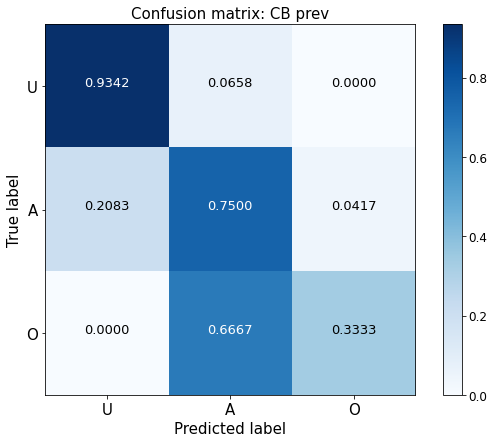

'print("CB new class prediction")\nclassification_report(to_pred_classes(Y_cbr_test_new,False),to_pred_classes(y_pred_test_cbr_new,False))\n\ncm = me.confusion_matrix(to_pred_classes(Y_cbr_test_new,False),to_pred_classes(y_pred_test_cbr_new,False),labels=labels_class)\nconfusion_matrix_plotting(cm,labels_class,True,"CB new")'

In [47]:
print("CB prev class prediction")
classification_report(to_pred_classes(Y_cbr_test_prev,False),to_pred_classes(y_pred_test_cbr_prev,False))

cm = me.confusion_matrix(to_pred_classes(Y_cbr_test_prev,False),to_pred_classes(y_pred_test_cbr_prev,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"CB prev")

CB new+var class prediction
              precision    recall  f1-score   support

           A       0.55      0.66      0.60        35
           O       0.67      0.47      0.55        17
           U       0.89      0.87      0.88        99

    accuracy                           0.77       151
   macro avg       0.70      0.67      0.68       151
weighted avg       0.78      0.77      0.78       151



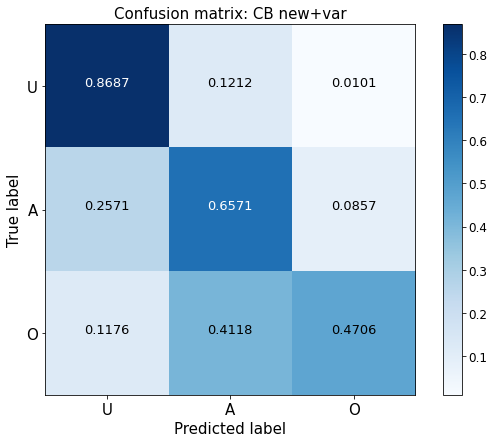

In [48]:
print("CB new+var class prediction")
classification_report(to_pred_classes(Y_cbr_test_var,False),to_pred_classes(y_pred_test_cbr_var,False))

cm = me.confusion_matrix(to_pred_classes(Y_cbr_test_var,False),to_pred_classes(y_pred_test_cbr_var,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"CB new+var")


Weighted Catboost  class prediction
              precision    recall  f1-score   support

           A       0.58      0.69      0.63        59
           O       0.69      0.42      0.52        26
           U       0.91      0.90      0.90       175

    accuracy                           0.80       260
   macro avg       0.72      0.67      0.69       260
weighted avg       0.81      0.80      0.80       260



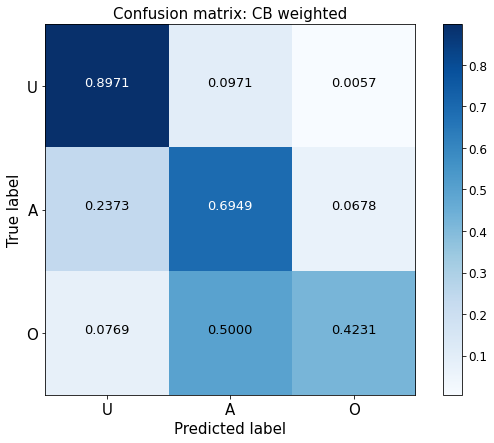

In [49]:
print("Weighted Catboost  class prediction")
classification_report(to_pred_classes(cb_weight_label,False),to_pred_classes(cb_weight_pred,False))

cm = me.confusion_matrix(to_pred_classes(cb_weight_label,False),to_pred_classes(cb_weight_pred,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"CB weighted")

PopPK class prediction
              precision    recall  f1-score   support

           A       0.50      0.11      0.19        35
           O       0.83      0.29      0.43        17
           U       0.71      0.98      0.82        99

    accuracy                           0.70       151
   macro avg       0.68      0.46      0.48       151
weighted avg       0.67      0.70      0.63       151



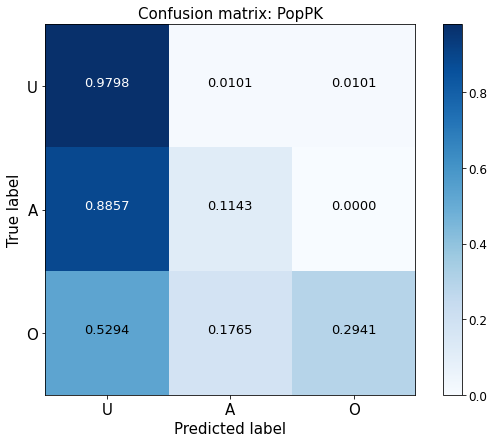

In [50]:
print("PopPK class prediction")
classification_report(to_pred_classes(Y_test_popPK,False),to_pred_classes(Y_popPK_pred ,False))

cm = me.confusion_matrix(to_pred_classes(Y_test_popPK,False),to_pred_classes(Y_popPK_pred,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"PopPK")


PopPK class prediction
              precision    recall  f1-score   support

           A       0.35      0.46      0.40        24
           O       0.50      0.56      0.53         9
           U       0.84      0.75      0.79        76

    accuracy                           0.67       109
   macro avg       0.56      0.59      0.57       109
weighted avg       0.70      0.67      0.68       109



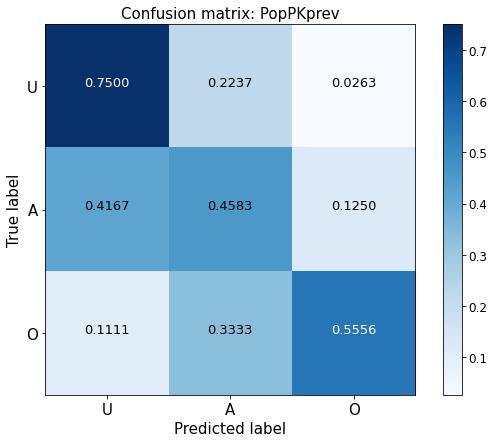

In [51]:
print("PopPK class prediction")
classification_report(to_pred_classes(Y_test_popPK_prev,False),to_pred_classes(Y_popPK_pred_prev ,False))

cm = me.confusion_matrix(to_pred_classes(Y_test_popPK_prev,False),to_pred_classes(Y_popPK_pred_prev,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"PopPKprev")

GP prev class prediction
              precision    recall  f1-score   support

           A       0.63      0.71      0.67        24
           O       0.60      0.33      0.43         9
           U       0.92      0.93      0.93        76

    accuracy                           0.83       109
   macro avg       0.72      0.66      0.67       109
weighted avg       0.83      0.83      0.83       109



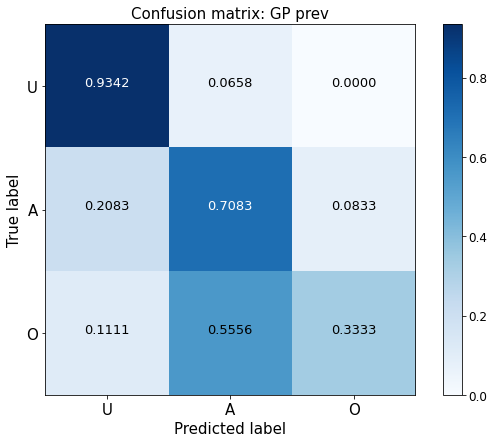

GP new class prediction
              precision    recall  f1-score   support

           A       0.50      0.54      0.52        35
           O       0.53      0.53      0.53        17
           U       0.88      0.85      0.86        99

    accuracy                           0.74       151
   macro avg       0.63      0.64      0.64       151
weighted avg       0.75      0.74      0.75       151



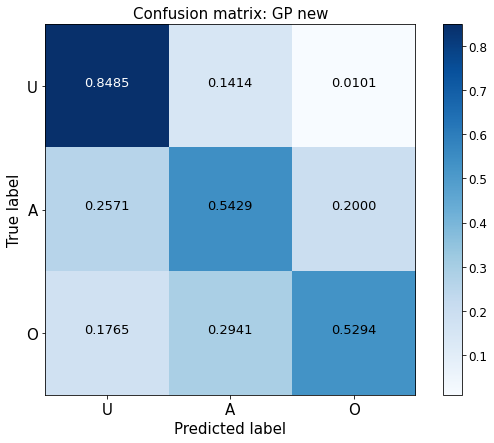

In [52]:
print("GP prev class prediction")
classification_report(to_pred_classes(Y_val_prev_dest,False),to_pred_classes(val_pred_prev,False))

cm = me.confusion_matrix(to_pred_classes(Y_val_prev_dest,False),to_pred_classes(val_pred_prev,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"GP prev")

print("GP new class prediction")
classification_report(to_pred_classes(Y_val_new_dest,False),to_pred_classes(val_pred_new,False))

cm = me.confusion_matrix(to_pred_classes(Y_val_new_dest,False),to_pred_classes(val_pred_new,False),labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"GP new")

Weighted GP report:
              precision    recall  f1-score   support

           A       0.55      0.61      0.58        59
           O       0.55      0.46      0.50        26
           U       0.90      0.89      0.89       175

    accuracy                           0.78       260
   macro avg       0.67      0.65      0.66       260
weighted avg       0.78      0.78      0.78       260



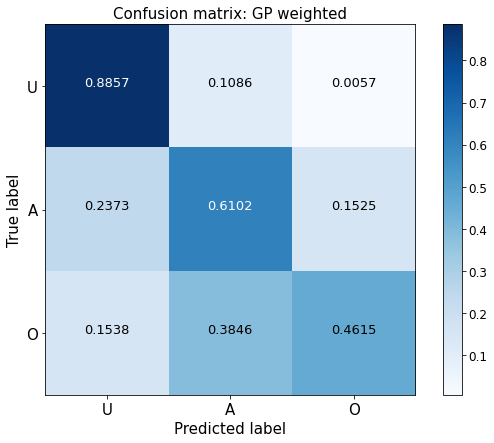

In [53]:
gp_tot_true = np.append(to_pred_classes(Y_val_new_dest,False),to_pred_classes(Y_val_prev_dest,False))
gp_tot_pred = np.append(to_pred_classes(val_pred_new,False),to_pred_classes(val_pred_prev,False))

print("Weighted GP report:")
classification_report(gp_tot_true,gp_tot_pred)

cm = me.confusion_matrix(gp_tot_true,gp_tot_pred,labels=labels_class)
confusion_matrix_plotting(cm,labels_class,True,"GP weighted")

# Uncertainty Visualizations

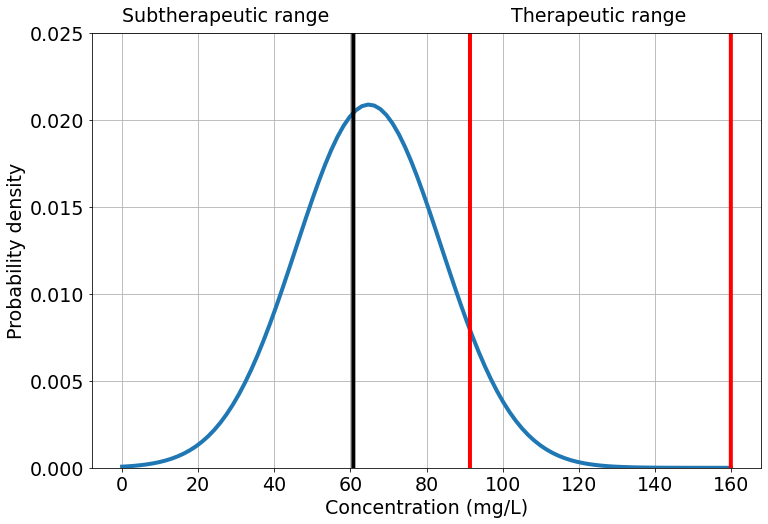

In [54]:
import scipy.stats as stats
fontsize_predef = 19
linewidth_predef = 4
idx = 40 

plt.figure(figsize=(12,8))
mu = y_pred_test_cbr_var[idx]
sigma = y_pred_sigm_var[idx]
x = np.linspace(0,160, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),linewidth=linewidth_predef)
plt.grid()
plt.plot([91.42,91.43],[0,0.03],color='red',linewidth=linewidth_predef)
plt.plot([159.99,160.00],[0,0.03],color='red',linewidth=linewidth_predef)
plt.plot([Y_cbr_test_var[idx]-0.01,Y_cbr_test_var[idx]],[0,0.03],color='black',linewidth=linewidth_predef)
plt.ylim([0,0.025])
x_start = 0.16
y_start = 0.9
plt.gcf().text(x_start+0,y_start, "Subtherapeutic range",fontsize=fontsize_predef)
plt.gcf().text(x_start+0.45,y_start, "Therapeutic range",fontsize=fontsize_predef)
plt.rc('axes', labelsize=fontsize_predef)    # fontsize of the x and y labels
plt.xticks(fontsize=fontsize_predef)    # fontsize of the tick labels
plt.yticks(fontsize=fontsize_predef)    # fontsize of the tick labels
plt.xlabel("Concentration (mg/L)",fontsize=fontsize_predef)
plt.ylabel("Probability density",fontsize=fontsize_predef)
plt.savefig("figures/pred_outp_new.jpeg")
plt.savefig("figures/pred_outp_new.pdf")
plt.savefig("figures/pred_outp_new.svg")

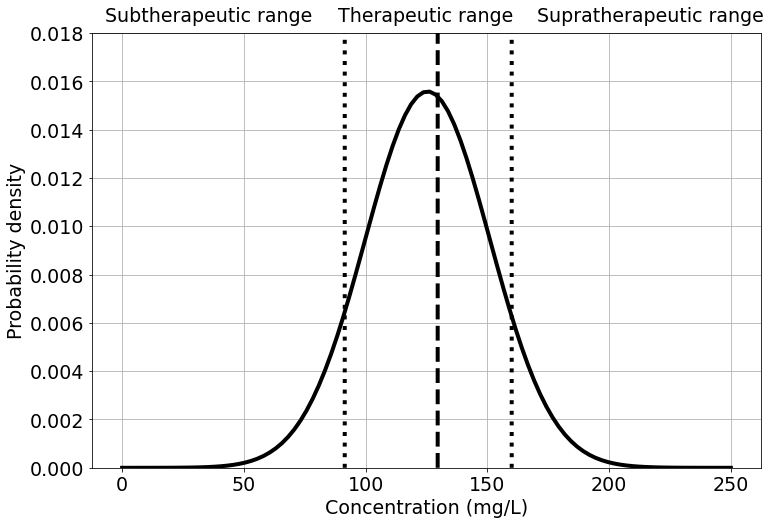

In [60]:
import scipy.stats as stats
fontsize_predef = 19
linewidth_predef = 4
idx = 67
 
plt.figure(figsize=(12,8))
mu = y_pred_test_cbr_prev[idx]
sigma = y_pred_sigm_prev[idx]
x = np.linspace(0,250, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),color='black',linewidth=linewidth_predef,label="Predictive distribution")
plt.grid()
plt.plot([91.42,91.43],[0,0.03],color='black',linestyle='dotted',linewidth=linewidth_predef,label="Therapeutic range")
plt.plot([159.99,160.00],[0,0.03],color='black',linestyle='dotted',linewidth=linewidth_predef)
plt.plot([Y_cbr_test_prev[idx]-0.01,Y_cbr_test_prev[idx]],[0,0.03],color='black',linestyle='dashed',linewidth=linewidth_predef,label="Observed concentration")
plt.ylim([0,0.018])
x_start = 0.14
y_start = 0.9
plt.gcf().text(x_start+0,y_start, "Subtherapeutic range",fontsize=fontsize_predef)
plt.gcf().text(x_start+0.27,y_start, "Therapeutic range",fontsize=fontsize_predef)
plt.gcf().text(x_start+0.5,y_start, "Supratherapeutic range",fontsize=fontsize_predef)
plt.rc('axes', labelsize=fontsize_predef)    # fontsize of the x and y labels
plt.xticks(fontsize=fontsize_predef)    # fontsize of the tick labels
plt.yticks(fontsize=fontsize_predef)    # fontsize of the tick labels
#plt.legend(fontsize=fontsize_predef-4)
plt.xlabel("Concentration (mg/L)")
plt.ylabel("Probability density")
plt.savefig("figures/pred_outp_prev.jpeg")
plt.savefig("figures/pred_outp_prev.pdf")
plt.savefig("figures/pred_outp_prev.svg")

In [46]:
#res,values,cov,ce = error_bar_quality_quantile(real_conc,preds,sigmas)
res_gp_prev,values,cov_gp_prev,ce_gp_prev = error_bar_quality_quantile(Y_val_prev_dest,val_pred_prev,sigma_prev)
res_gp_new,values,cov_gp_new,ce_gp_new = error_bar_quality_quantile(Y_val_new_dest,val_pred_new,sigma_new)

#res2,values2,cov2,ce2 = error_bar_quality_quantile(cb_weight_label,cb_weight_pred,cb_weight_sigm)
res_gbt_prev,values,cov_gbt_prev,ce_gbt_prev = error_bar_quality_quantile(Y_cbr_test_prev,y_pred_test_cbr_prev,y_pred_sigm_prev)
res_gbt_new,values,cov_gbt_new,ce_gbt_new = error_bar_quality_quantile(Y_cbr_test_var,y_pred_test_cbr_var,y_pred_sigm_var)

--


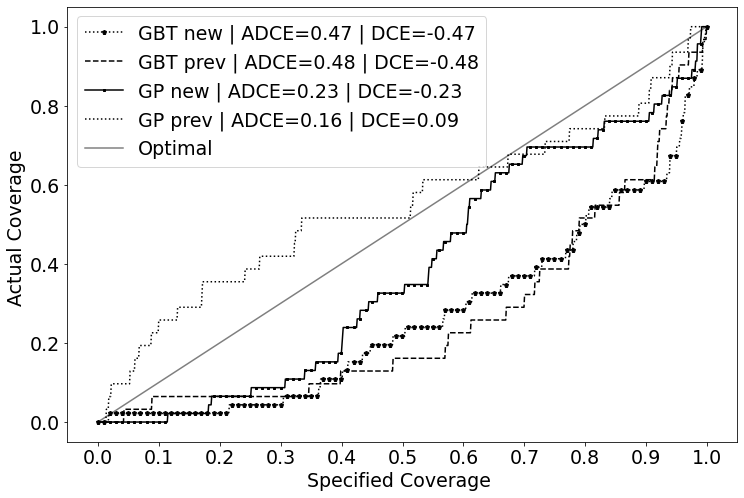

In [47]:
fontsize_predef = 19

plt.figure(figsize=(12,8))
ax = plt.gca()
print("--")

#diff = np.sum(np.abs(np.subtract(values,res)))
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gbt_new,'kp:',label='GBT new | ADCE='+str(np.round(cov_gbt_new,2))+' | DCE='+str(np.round(ce_gbt_new,2)),markevery=10,markersize=5)
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gbt_prev,'k--',label='GBT prev | ADCE='+str(np.round(cov_gbt_prev,2))+' | DCE='+str(np.round(ce_gbt_prev,2)),markevery=10)
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gp_new,'ks-',label='GP new | ADCE='+str(np.round(cov_gp_new,2))+' | DCE='+str(np.round(ce_gp_new,2)),markevery=10,markersize=2)
plt.plot(np.arange(0,1.0,1.0/len(values)),res_gp_prev,'k:',label='GP prev | ADCE='+str(np.round(cov_gp_prev,2))+' | DCE='+str(np.round(ce_gp_prev,2)),markevery=100)
plt.plot(np.arange(0,1.0,1.0/len(values)),values,label='Optimal',color="black",alpha=0.5)



plt.xticks(np.arange(0, 1.1, 0.1),np.round(values[0::100],2), fontsize=fontsize_predef)#, np.round(values[0::10],2))
plt.yticks(fontsize=fontsize_predef)
#plt.locator_params(axis='x', nbins=len(values)/10)
plt.xlabel('Specified Coverage ',fontsize=fontsize_predef)
plt.ylabel('Actual Coverage ',fontsize=fontsize_predef)
    
plt.legend(loc='upper left', fontsize=fontsize_predef)

if internal_test_bool:
    plt.legend(loc='lower right', fontsize=fontsize_predef)
    plt.savefig("figures/coverage_plot_GUH.pdf")
    plt.savefig("figures/coverage_plot_GUH.jpeg")
    plt.savefig("figures/coverage_plot_GUH.svg")
else:
    plt.legend(loc='upper left', fontsize=fontsize_predef)
    plt.savefig("figures/coverage_plot_UMCG.pdf")
    plt.savefig("figures/coverage_plot_UMCG.jpeg")
    plt.savefig("figures/coverage_plot_UMCG.svg")
    
plt.show() 

In [58]:
gp_prob = False
print_all = True

if gp_prob: 

    classes = np.append(to_pred_classes(val_pred_new,False),to_pred_classes(val_pred_prev,False))
    real = np.append(to_pred_classes(Y_val_new_dest,False),to_pred_classes(Y_val_prev_dest,False))
    preds = np.append(val_pred_new,val_pred_prev)
    sigmas = np.append(sigma_new,sigma_prev)
    real_conc = np.append(Y_val_new_dest,Y_val_prev_dest)
else:
    
    classes = to_pred_classes(cb_weight_pred,False)
    real = to_pred_classes(cb_weight_label,False)
    preds = cb_weight_pred
    sigmas = cb_weight_sigm
    real_conc = cb_weight_label
    
under_avg = []
perfect_avg = []
over_avg = []
    
for i in range(0,len(classes)):
    pred = preds[i]
    sigma = sigmas[i]
    real_stat = real[i]
    status = classes[i]
    real_conc_i = real_conc[i]
    
    
    
    underdosing_und = 0
    underdosing_up = 4*MIC
    up_diff = (underdosing_up-pred)/sigma
    down_diff = (-100000*MIC-pred)/sigma
    underdosing = (erf(up_diff/sqrt(2)) - erf(down_diff/sqrt(2)) )*50

    perfect_und = 4*MIC
    perfect_up = toxic_threshold
    up_diff = (perfect_up-pred)/sigma
    down_diff = (perfect_und-pred)/sigma
    perfect = (erf(up_diff/sqrt(2)) - erf(down_diff/sqrt(2)) )*100/2
    
    toxic_und = toxic_threshold
    down_diff = (toxic_und-pred)/sigma
    toxic = (1 - erf(down_diff/sqrt(2)) )*100/2
    
    print("Predicts a "+status)
    print(i)
    if status != real[i]:
        if real_stat == "U":
            print("\tThe real status was: Underdosing, certainty of this status was {0:.2f}% ".format(underdosing))
        elif real_stat == "A":
            print("\tThe real status was: Adequate dosing, certainty of this status was {0:.2f}%".format(perfect))
        else:
            print("\tThe real status was: Overdosing, certainty of this status was {0:.2f}%".format(toxic))
      
    if status == "Underdosing" and status != real[i] :
        under_avg.append(underdosing)
    elif status == "Adequate dosing" and status != real[i]:
        perfect_avg.append(perfect)
    elif status == "Overdosing" and status != real[i] and real[i]=="Underdosing":
        over_avg.append(toxic)

    #if status == "Underdosing":
    print("\tUnderdosing with {0:.2f}% certainty ".format(underdosing))
    #elif status == "Adequate dosing":
    print("\tAdequate dosing with {0:.2f}% certainty".format(perfect))
    #else:
    print("\tOverdosing with {0:.2f}% certainty".format(toxic))
    
    if print_all:
        print("Predicted average value  %.2f (+/- %.2f) mg/L" % (pred,sigma))
        print("Observed value %.2f mg/L" % (real_conc_i))
    print("----")
    
print("Average underdosing certainty: %.2f"%(np.mean(under_avg)))
print("Average Adequate certainty: %.2f"%(np.mean(perfect_avg)))
print("Average overdosing certainty: %.2f"%(np.mean(over_avg)))

Predicts a U
0
	Underdosing with 98.66% certainty 
	Adequate dosing with 1.34% certainty
	Overdosing with 0.00% certainty
Predicted average value  45.10 (+/- 20.92) mg/L
Observed value 33.39 mg/L
----
Predicts a U
1
	Underdosing with 98.73% certainty 
	Adequate dosing with 1.27% certainty
	Overdosing with 0.00% certainty
Predicted average value  43.35 (+/- 21.50) mg/L
Observed value 33.17 mg/L
----
Predicts a U
2
	Underdosing with 98.84% certainty 
	Adequate dosing with 1.16% certainty
	Overdosing with 0.00% certainty
Predicted average value  42.22 (+/- 21.67) mg/L
Observed value 39.37 mg/L
----
Predicts a U
3
	Underdosing with 98.38% certainty 
	Adequate dosing with 1.62% certainty
	Overdosing with 0.00% certainty
Predicted average value  45.24 (+/- 21.58) mg/L
Observed value 32.09 mg/L
----
Predicts a U
4
	Underdosing with 94.68% certainty 
	Adequate dosing with 5.32% certainty
	Overdosing with 0.00% certainty
Predicted average value  56.10 (+/- 21.88) mg/L
Observed value 37.25 mg/L


Mean of empty slice.
invalid value encountered in double_scalars


# SHAP

In [59]:
#cbr_var, cbr_prev
import matplotlib.cm as cm

In [60]:
shap_var_pd = X_cbr_train_prev.rename(columns={"Cl8u_eGFR": "CLCR","Creat_s":"Serum creatinine","Bili":"Bilirubine","Length":"Height"})

In [61]:
plt.rcParams['figure.dpi'] = 300

In [62]:
shap_var_pd_var_test = X_cbr_test_var.rename(columns={"ClCr": "CL$_{CR}$","Serum Creat":"Serum creatinine","Bilirubine":"Bilirubin","Albumine":"Albumin","Thrombo":"Thrombocytes","Length":"Height"})
shap_var_pd_var_train = X_cbr_train_var.rename(columns={"ClCr": "CL$_{CR}$","Serum Creat":"Serum creatinine","Bilirubine":"Bilirubin","Albumine":"Albumin","Thrombo":"Thrombocytes","Length":"Height"})

In [63]:
shap_var_pd_test = X_cbr_test_prev.rename(columns={"ClCr": "CL$_{CR}$","Serum Creat":"Serum creatinine","Bilirubine":"Bilirubin","prevCon":"Previous concentration","Albumine":"Albumin","Thrombo":"Platelets","DoseHour":"Dose per hour","Length":"Height"})
shap_prev_pd_train = X_cbr_train_prev.rename(columns={"ClCr": "CL$_{CR}$","Serum Creat":"Serum creatinine","Bilirubine":"Bilirubin","prevCon":"Previous concentration","Albumine":"Albumin","Thrombo":"Platelets","DoseHour":"Dose per hour","Length":"Height"})

In [ ]:
explainer = shap.TreeExplainer(cbr_prev)
shap_values = explainer.shap_values(X_cbr_train_prev)
my_cmap = plt.get_cmap('viridis')

explainer_prior = shap.TreeExplainer(cbr_var)
shap_values_prior = explainer_prior.shap_values(X_cbr_train_var)

plt.figure(figsize=(10,12))

plt.subplot(2,1,1)
shap.summary_plot(shap_values_prior, shap_var_pd_var_train,show=False,plot_size=None)
plt.subplot(2,1,2)
shap.summary_plot(shap_values, shap_prev_pd_train,show=False,plot_size=None)#,feature_names=["Length","Serum creat.","Thrombo","Bilirubine","Albumine","DoseHour","Prev. Con.","CLCR"])
plt.tight_layout()
#plt.show()

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            
plt.savefig("figures/shap_cbr.pdf")
plt.savefig("figures/shap_cbr.jpeg")
plt.savefig("figures/shap_cbr.svg")
plt.savefig("figures/shap_cbr.tif")
plt.savefig("figures/shap_cbr.eps")

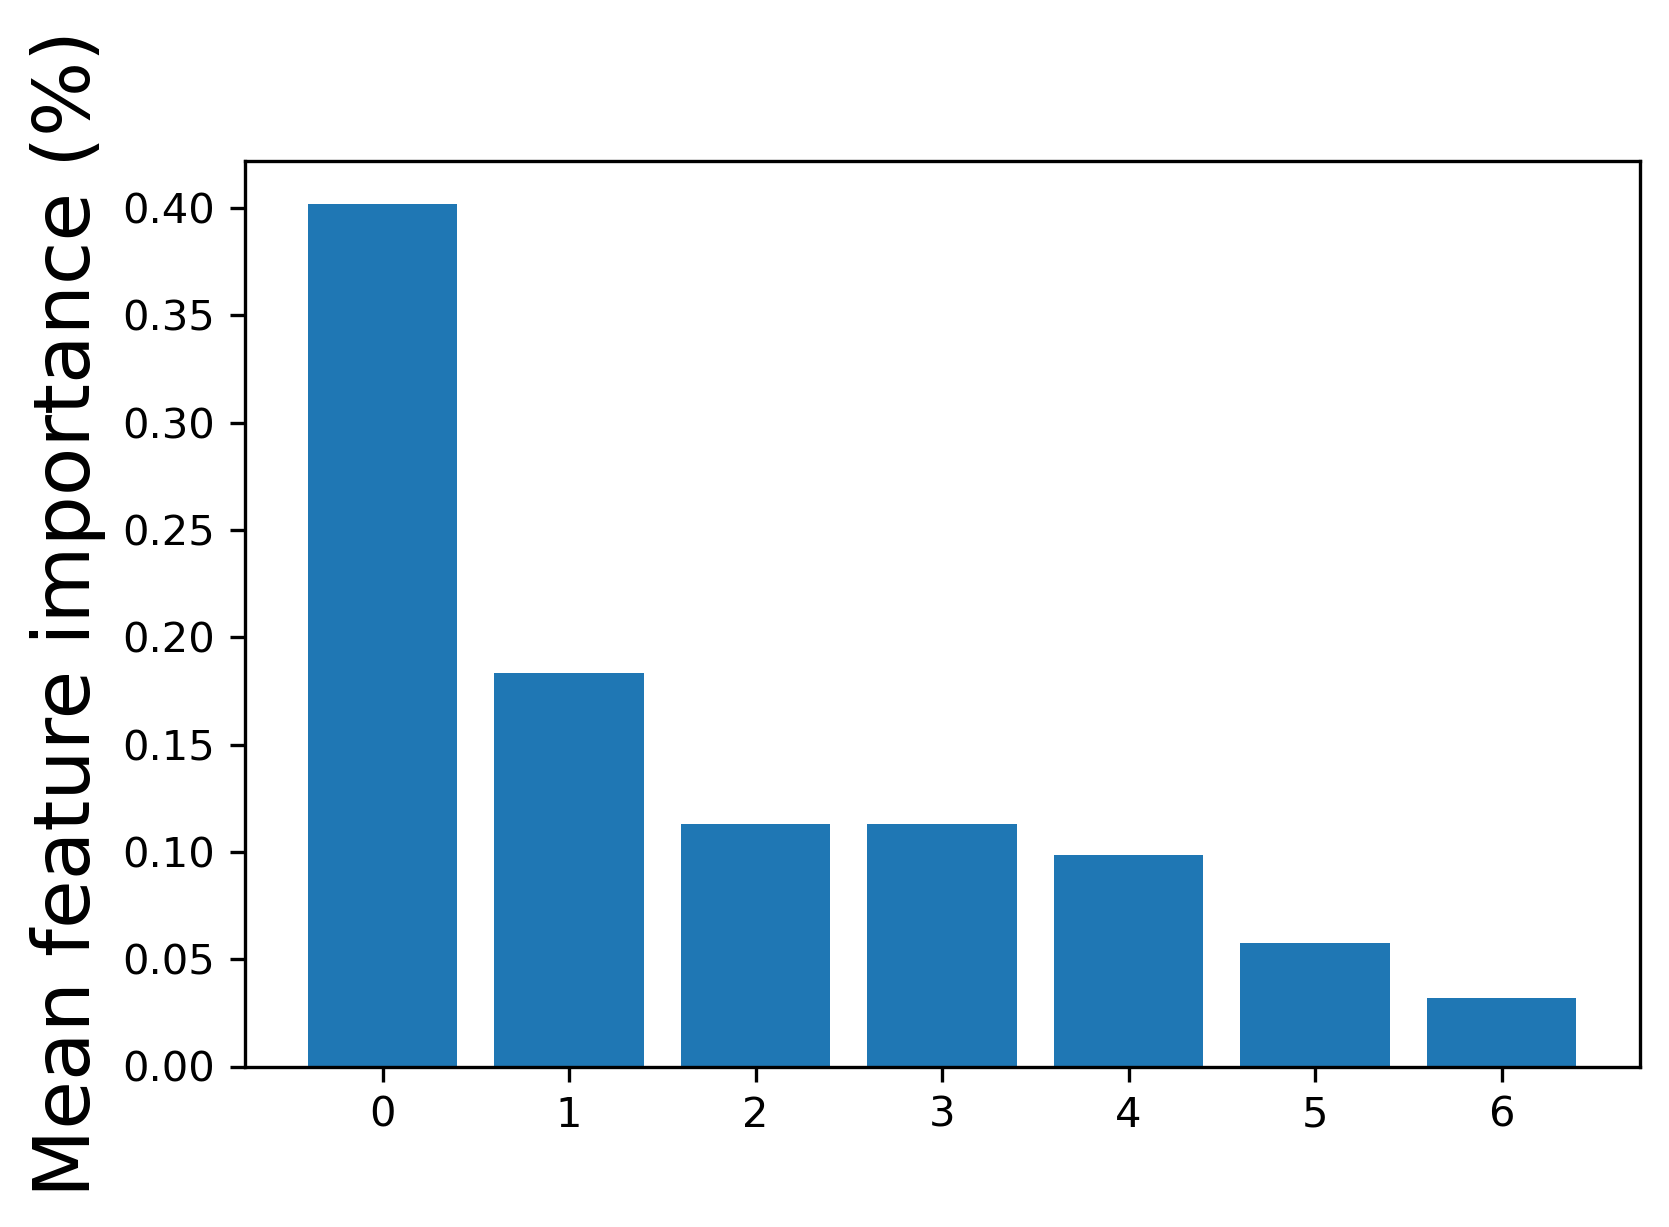

In [67]:
plt.figure(figsize=(6,4))
indices = np.argsort(fi_shap)[::-1]
plt.bar(range(len(fi_shap)),fi_shap[indices])
#plt.xticks(range(len(fi_shap)), X_cbr_train_var.columns[indices],rotation=90,fontsize=11)
plt.ylabel("Mean feature importance (%)")#,fontsize=13)
#plt.tight_layout()
plt.show()

Height                    170.00000
Serum creatinine            0.51000
Platelets                 248.00000
Bilirubin                   1.70000
Albumin                    20.00000
Dose per hour             602.52123
Previous concentration    173.40000
CL$_{CR}$                  72.60270
Name: 548, dtype: float64


<Figure size 1800x1200 with 0 Axes>

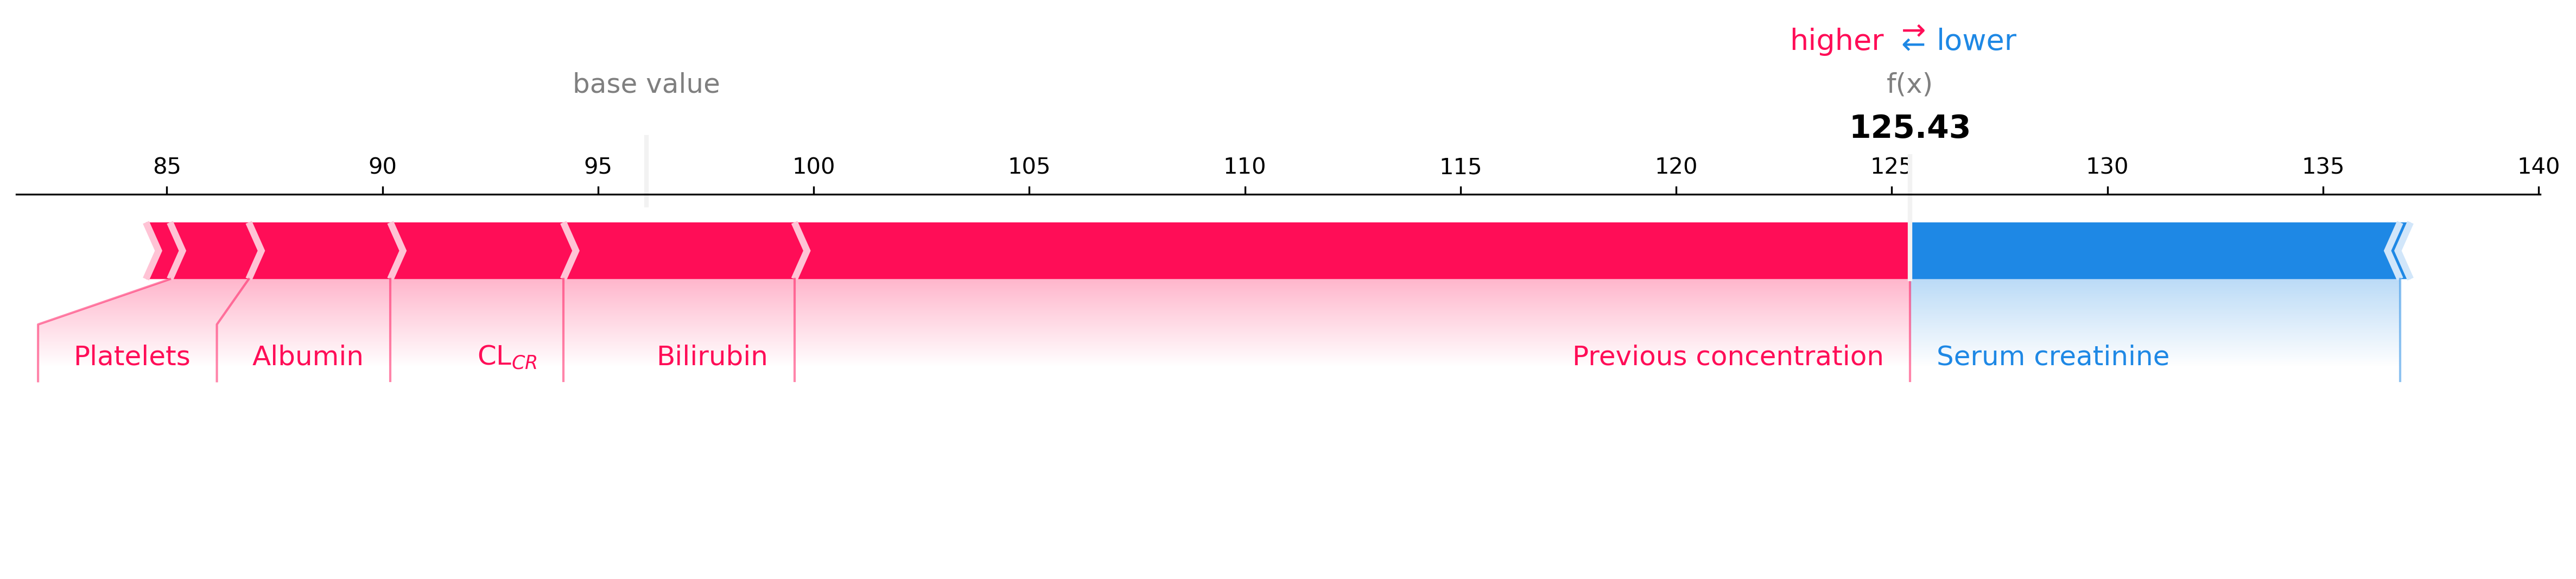

In [69]:
explainer = shap.TreeExplainer(cbr_prev)
shap_values_test = explainer.shap_values(X_cbr_test_prev)
print(shap_var_pd_test.iloc[67,:])
plt.figure()
plt.gcf().subplots_adjust(top=5)
fig = shap.force_plot(explainer.expected_value, shap_values_test[67,:], shap_var_pd_test.iloc[67,:].index, plot_cmap=["#7fcc12","#560aa5"],matplotlib=True,show=False)#.savefig("figures/patient_prev.jpeg")
plt.savefig("figures/patient_prev.jpeg", bbox_inches="tight")
plt.savefig("figures/patient_prev.pdf", bbox_inches="tight")
plt.savefig("figures/patient_prev.svg", bbox_inches="tight")

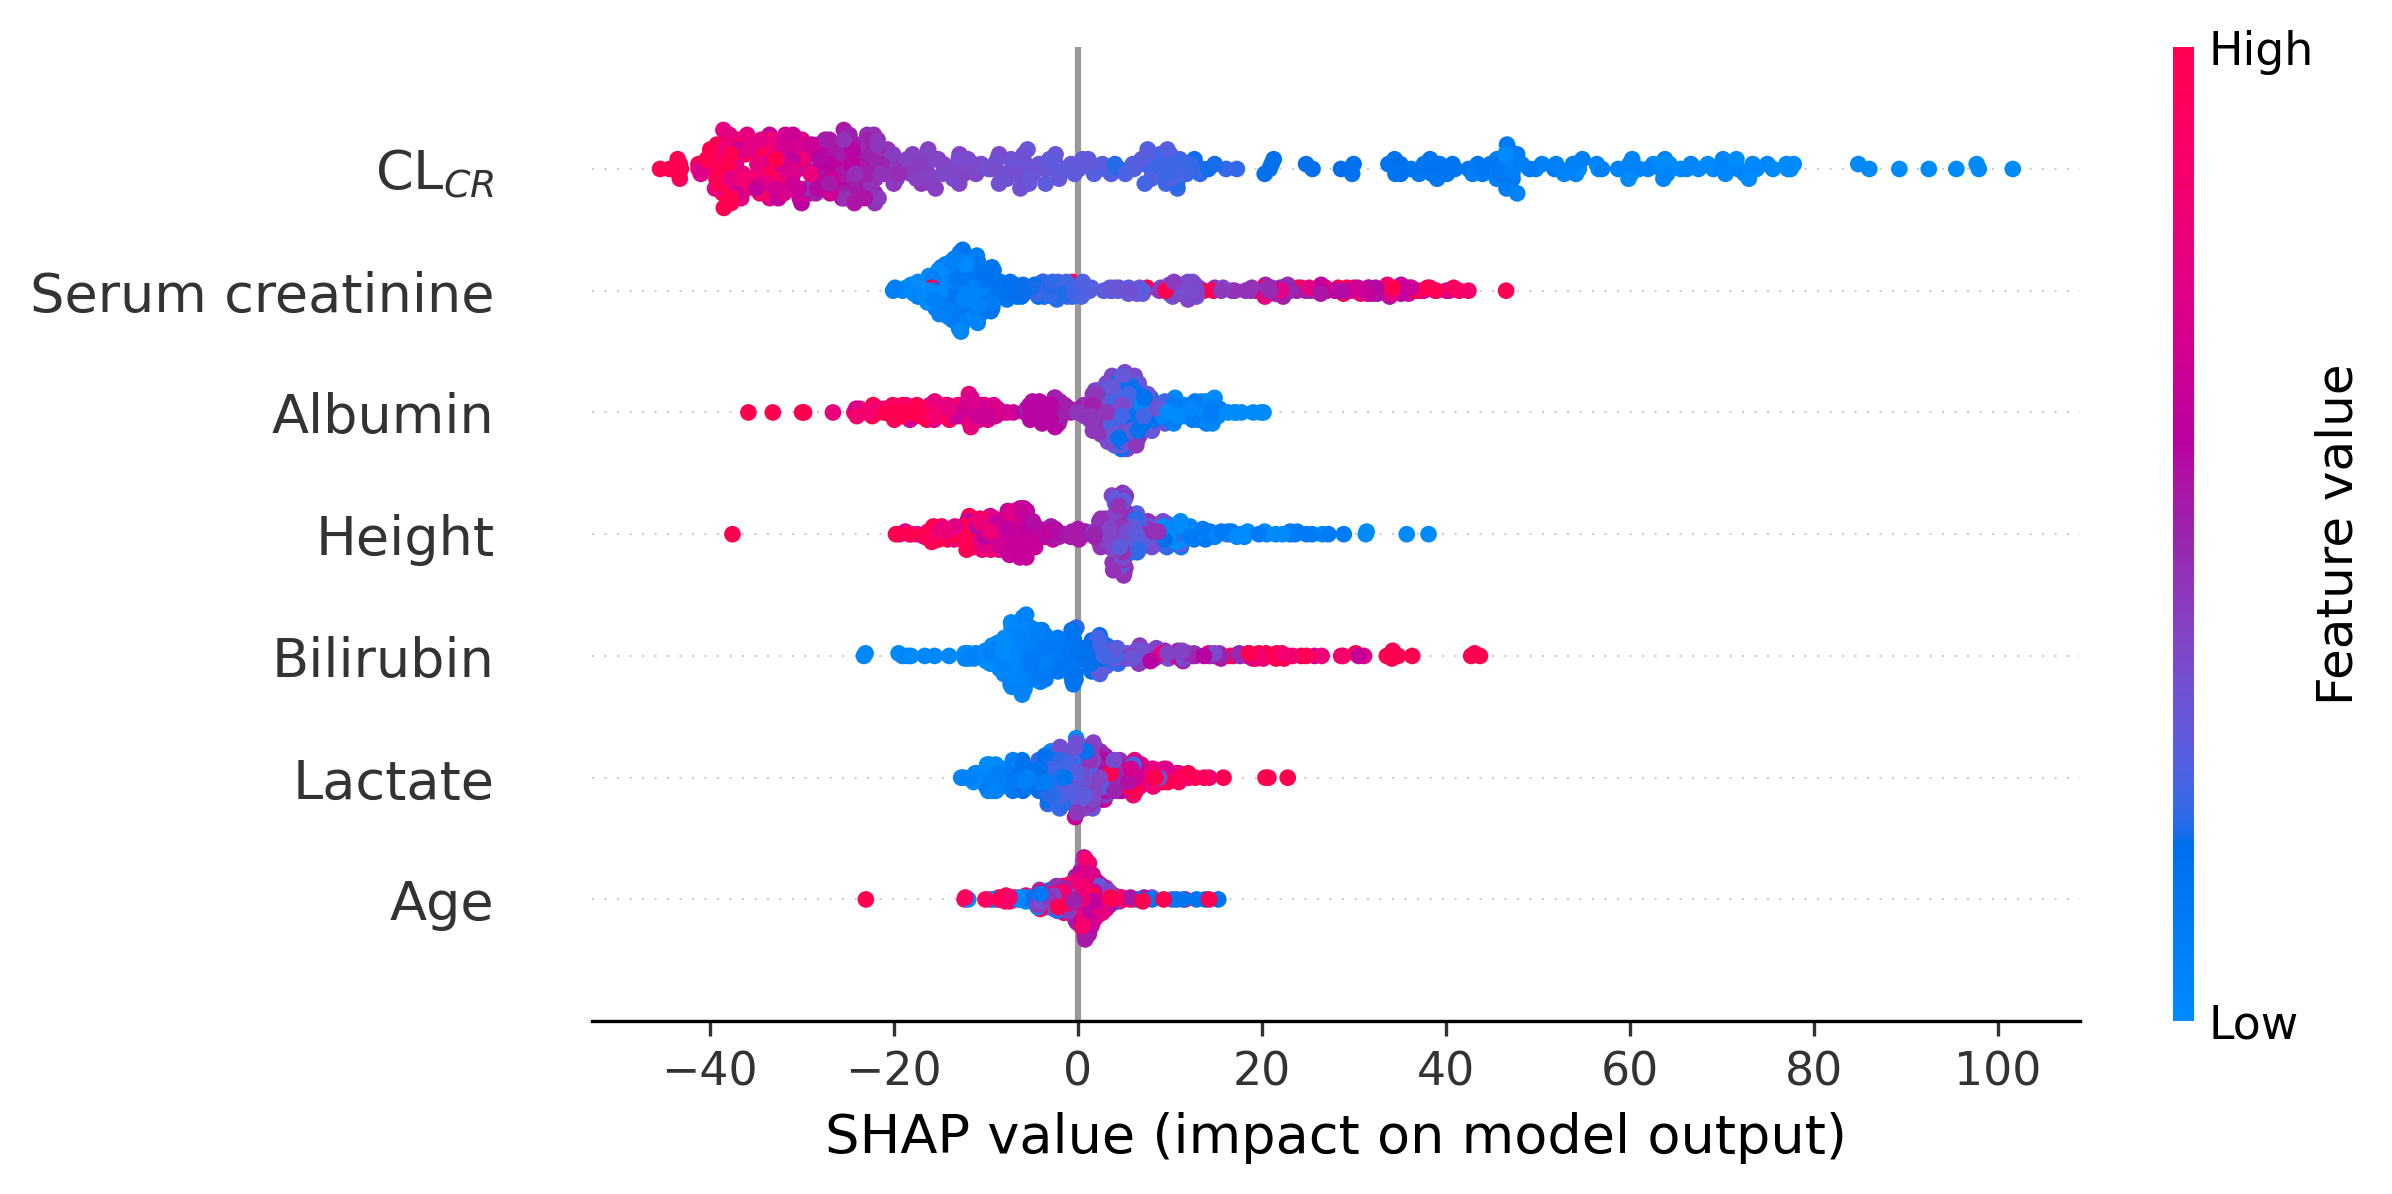

<Figure size 1800x1200 with 0 Axes>

In [70]:
explainer = shap.TreeExplainer(cbr_var)
shap_values = explainer.shap_values(X_cbr_train_var)
shap.summary_plot(shap_values, shap_var_pd_var_train)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)
            
shap_values_test = explainer.shap_values(X_cbr_test_var)
#shap.force_plot(explainer.expected_value, shap_values_test[26,:], X_cbr_test_var.iloc[26,:],matplotlib=True)

Age                  59.0000
Height              175.0000
Lactate              11.7000
Serum creatinine      0.7200
Bilirubin             0.6000
Albumin              33.0000
CL$_{CR}$            90.9311
Name: 265, dtype: float64


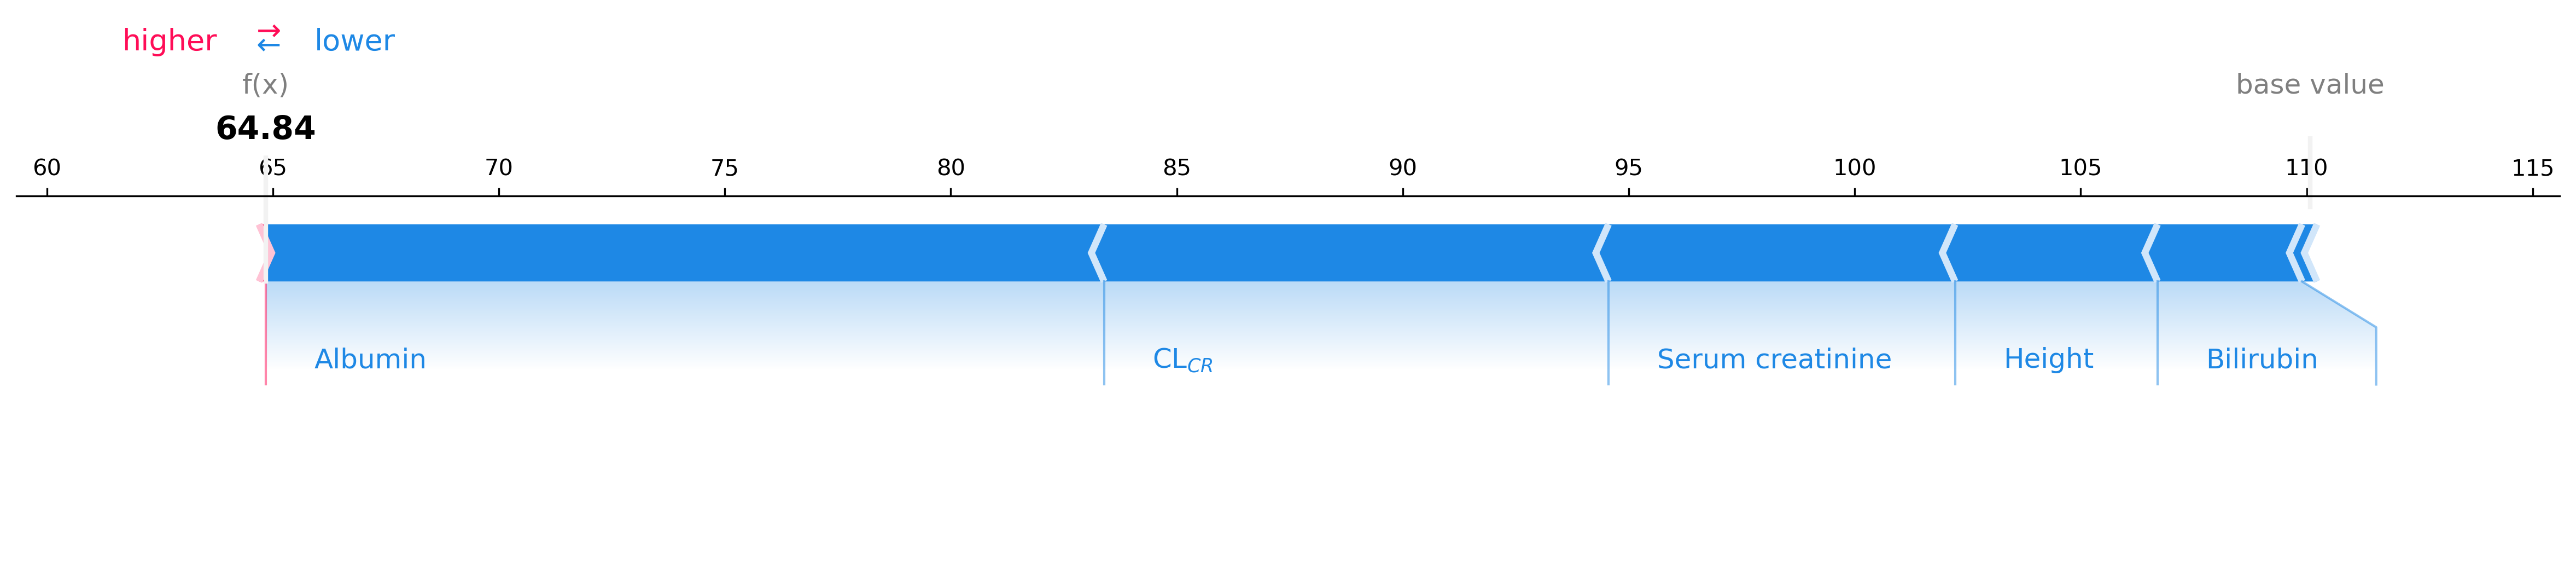

In [86]:
print(shap_var_pd_var_test.iloc[40,:])
shap.force_plot(explainer.expected_value, shap_values_test[40,:], shap_var_pd_var_test.iloc[40,:].index, plot_cmap=["#7fcc12","#560aa5"],matplotlib=True,show=False)
plt.savefig("figures/patient_priori.jpeg", bbox_inches="tight")
plt.savefig("figures/patient_priori.pdf", bbox_inches="tight")
plt.savefig("figures/patient_priori.svg", bbox_inches="tight")

# Bland-Altmann

In [46]:
save = False
log_plot = True


if log_plot:
    Y_val_plot_cbr = np.log(Y_cbr_test_var)
    Y_val_plot_pred_cbr= np.log(y_pred_test_cbr_var)
else:
    Y_val_plot_cbr = Y_cbr_test_var
    Y_val_plot_pred_cbr= y_pred_test_cbr_var

diff_cbr = np.subtract(Y_val_plot_pred_cbr,Y_val_plot_cbr)

md_cbr = np.mean(diff_cbr)
sd_cbr = np.std(diff_cbr)

if log_plot:
    Y_val_plot_poppk =np.log( Y_test_popPK )
    Y_val_plot_pred_poppk= np.log(Y_popPK_pred)
else:
    Y_val_plot_poppk =Y_test_popPK 
    Y_val_plot_pred_poppk= Y_popPK_pred

diff_poppk = np.subtract(Y_val_plot_pred_poppk,Y_val_plot_poppk)

md_poppk = np.mean(diff_poppk)
sd_poppk = np.std(diff_poppk)

if log_plot:
    Y_val_plot_cbr_prev =  np.log(Y_cbr_test_prev )
    Y_val_plot_pred_cbr_prev= np.log(y_pred_test_cbr_prev)
else:
    Y_val_plot_cbr_prev =  Y_cbr_test_prev 
    Y_val_plot_pred_cbr_prev= y_pred_test_cbr_prev

diff_cbr_prev = np.subtract(Y_val_plot_pred_cbr_prev,Y_val_plot_cbr_prev)

md_cbr_prev = np.mean(diff_cbr_prev)
sd_cbr_prev = np.std(diff_cbr_prev)

if log_plot:
    Y_val_plot_poppk_prev = np.log(Y_test_popPK_prev)
    Y_val_plot_pred_poppk_prev= np.log(Y_popPK_pred_prev)
else:
    Y_val_plot_poppk_prev = Y_test_popPK_prev
    Y_val_plot_pred_poppk_prev= Y_popPK_pred_prev

diff_poppk_prev = np.subtract(Y_val_plot_pred_poppk_prev,Y_val_plot_poppk_prev)

md_poppk_prev = np.mean(diff_poppk_prev)
sd_poppk_prev = np.std(diff_poppk_prev)

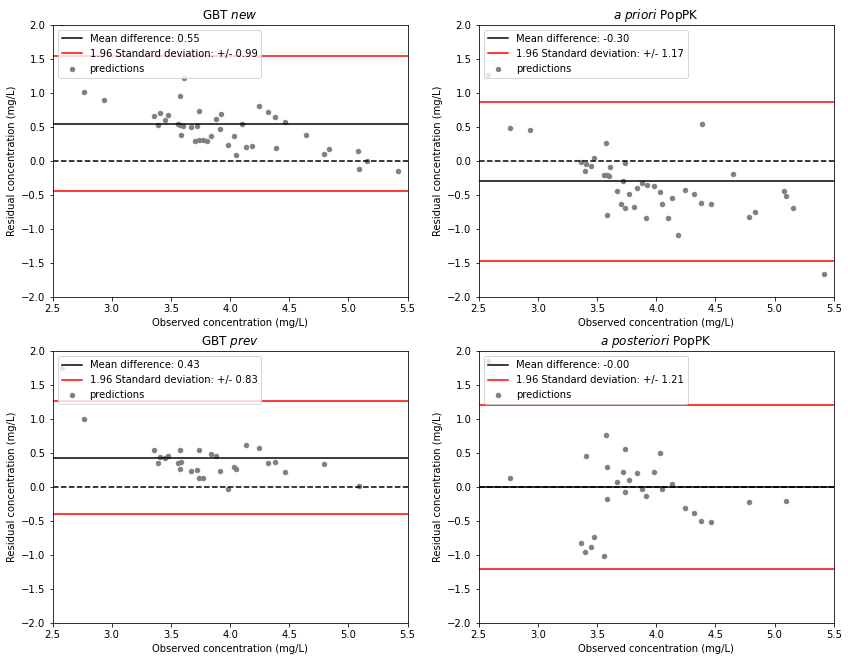

In [47]:
Y_val_plot1 = Y_val_plot_cbr
diff1 = diff_cbr
md1 = md_cbr
sd1 = sd_cbr

Y_val_plot2 = Y_val_plot_poppk
diff2 = diff_poppk
md2 = md_poppk
sd2 = sd_poppk

Y_val_plot3 = Y_val_plot_cbr_prev
diff3 = diff_cbr_prev
md3 = md_cbr_prev
sd3 = sd_cbr_prev

Y_val_plot4 = Y_val_plot_poppk_prev
diff4 = diff_poppk_prev
md4 = md_poppk_prev
sd4 = sd_poppk_prev
    
f, axes = plt.subplots(2, 2,figsize=(14,11))

if internal_test_bool:
    if log_plot:
        y_plot_limit = 1.5
        x_plot_limit = 3
    else:
        y_plot_limit = 270
else:
    if log_plot:
        y_plot_limit = 2
        x_plot_limit = 2.5
    else:
        y_plot_limit = 210

axes[0,0].scatter(Y_val_plot1,diff1,label='predictions',color='gray',s=20)
axes[0,0].axhline(md1,color='black',label='Mean difference: %.2f' % (md1))
axes[0,0].axhline(md1+1.96*sd1,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd1))
axes[0,0].axhline(md1-1.96*sd1,color='red')
axes[0,0].axhline(0,color='black',ls="--")
axes[0,0].set_xlabel('Observed concentration (mg/L)')
axes[0,0].set_ylabel('Residual concentration (mg/L)')
axes[0,0].legend(loc="upper left")
axes[0,0].set_title("GBT $\it{new}$")
axes[0,0].set_ylim((-y_plot_limit,y_plot_limit))
if log_plot:
    axes[0,0].set_xlim((x_plot_limit,x_plot_limit+3))

axes[0,1].scatter(Y_val_plot2,diff2,label='predictions',color='gray',s=20)
axes[0,1].axhline(md2,color='black',label='Mean difference: %.2f' % (md2))
axes[0,1].axhline(md2+1.96*sd2,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd2))
axes[0,1].axhline(md2-1.96*sd2,color='red')
axes[0,1].axhline(0,color='black',ls="--")
axes[0,1].set_xlabel('Observed concentration (mg/L)')
axes[0,1].set_ylabel('Residual concentration (mg/L)')
axes[0,1].legend(loc="upper left")
axes[0,1].set_title("$\it{a}$ $\it{priori}$ PopPK")
axes[0,1].set_ylim((-y_plot_limit,y_plot_limit))
if log_plot:
    axes[0,1].set_xlim((x_plot_limit,x_plot_limit+3))

axes[1,0].scatter(Y_val_plot3,diff3,label='predictions',color='gray',s=20)
axes[1,0].axhline(md3,color='black',label='Mean difference: %.2f' % (md3))
axes[1,0].axhline(md3+1.96*sd3,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd3))
axes[1,0].axhline(md3-1.96*sd3,color='red')
axes[1,0].axhline(0,color='black',ls="--")
axes[1,0].set_xlabel('Observed concentration (mg/L)')
axes[1,0].set_ylabel('Residual concentration (mg/L)')
axes[1,0].legend(loc="upper left")
axes[1,0].set_title("GBT $\it{prev}$")
axes[1,0].set_ylim((-y_plot_limit,y_plot_limit))
if log_plot:
    axes[1,0].set_xlim((x_plot_limit,x_plot_limit+3))

axes[1,1].scatter(Y_val_plot4,diff4,label='predictions',color='gray',s=20)
axes[1,1].axhline(md4,color='black',label='Mean difference: %.2f' % (md4))
axes[1,1].axhline(md4+1.96*sd4,color='red',label='1.96 Standard deviation: +/- {0:.2f}'.format(1.96*sd4))
axes[1,1].axhline(md4-1.96*sd4,color='red')
axes[1,1].axhline(0,color='black',ls="--")
axes[1,1].set_xlabel('Observed concentration (mg/L)')
axes[1,1].set_ylabel('Residual concentration (mg/L)')
axes[1,1].legend(loc="upper left")
axes[1,1].set_title("$\it{a}$ $\it{posteriori}$ PopPK")
axes[1,1].set_ylim((-y_plot_limit,y_plot_limit))
if log_plot:
    axes[1,1].set_xlim((x_plot_limit,x_plot_limit+3))

if save:
    if internal_test_bool:
        f.savefig("figures/blandt_altman_guh.pdf")
        f.savefig("figures/blandt_altman_guh.jpeg")
        f.savefig("figures/blandt_altman_guh.svg")
    else:
        f.savefig("figures/blandt_altman_umcg.pdf")
        f.savefig("figures/blandt_altman_umcg.jpeg")
        f.savefig("figures/blandt_altman_umcg.svg")